Trey Tuscai and Gordon Doore

Spring 2025

CS 444: Deep Learning

Project 2: Branch Neural Networks

#### Week 2: Residual networks

The focus this week is on the ResNet architecture. You will build several neural networks in the ResNet family and and train them on CIFAR-10 and CIFAR-100.

In [13]:
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt

plt.style.use(['seaborn-v0_8-colorblind', 'seaborn-v0_8-darkgrid'])
plt.rcParams.update({'font.size': 20})

np.set_printoptions(suppress=True, precision=7)

# Automatically reload your external source code
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Task 6: The Residual Block

This task focuses on implementing and testing the **Residual Block** in preparation of creating the first ResNet (**ResNet-8**). 

Much like how Inception Blocks represent the building blocks of Inception Net, stacks of Residual Blocks represent the basis of ResNet. Residual Blocks possess a simpler structure than Inception Blocks — they only contain two parallel branches with fewer layers. Here is a refresher on the structure of the branches:

**Main branch:** sequence of two 2D convolutional layers.

**Residual branch:** the input signal to the Residual Block passes through "as-is", without modification (usually).

Like Inception Block, the output of both branches comes together at the end of the block. However, the branch outputs are SUMMED together rather than being concatenated.


This is the story for most Residual Blocks, however, like most CNNs:
1. the spatial resolution of the activations occasionally decreases
2. the number of conv filters/neurons increases

as we go deeper in a ResNet. Both of these factors tend to change *at the same time* in a small number of Residual Blocks located at various depths of the ResNet. Put another way, the spatial resolution and number of filters tends to remain constant across most successive Residual Blocks and they only changes in a few blocks throughout the net.
1. The decrease in spatial resolution is implemented in these small number of Residual Blocks with a convolutional stride > 1.
2. A 1x1 convolutional layer is needed as the "special sauce" along the residual branch to make the shapes of signals in both branches match (*otherwise they could not be summed!*).

### 6a. Implement and test the Residual Block

The class is in `residual_block.py`.

In [14]:
from residual_block import ResidualBlock

#### Test: `ResidualBlock` Stride 1 (1/2)

In [15]:
# Testing architecture and shapes
# Stride 1
tf.random.set_seed(0)
res1 = ResidualBlock('TestResidualBlock_S1', 7, prev_layer_or_block=None, strides=1)
res1(tf.ones([1, 4, 4, 7]))
print(res1)

TestResidualBlock_S1:
	Conv2D layer output(TestResidualBlock_S1/main_3x3conv_2) shape: [1, 4, 4, 7]
	Conv2D layer output(TestResidualBlock_S1/main_3x3conv_1) shape: [1, 4, 4, 7]


The above cell should print:

```
TestResidualBlock_S1:
	Conv2D layer output(TestResidualBlock_S1/main_3x3conv_2) shape: [1, 4, 4, 7]
	Conv2D layer output(TestResidualBlock_S1/main_3x3conv_1) shape: [1, 4, 4, 7]
```

In [16]:
# Test activations
tf.random.set_seed(0)
net_acts1 = res1(tf.random.uniform([2, 4, 4, 7]))
print(f'The shape of the netAct output from the block is {net_acts1.shape} and should be (2, 4, 4, 7)')
print(f'The first few activations are:\n{net_acts1[0,:,:, 0]}')
print('and should be:')
print('''[[0.        0.520823  0.1888617 0.       ]
 [0.        0.7621396 0.1734907 0.8486798]
 [0.        0.6156113 0.4272216 0.       ]
 [0.5561852 0.4888234 1.0138503 0.5533389]]''')

The shape of the netAct output from the block is (2, 4, 4, 7) and should be (2, 4, 4, 7)
The first few activations are:
[[0.        0.5208229 0.1888617 0.       ]
 [0.        0.7621396 0.1734906 0.8486798]
 [0.        0.6156112 0.4272216 0.       ]
 [0.5561852 0.4888234 1.0138503 0.5533389]]
and should be:
[[0.        0.520823  0.1888617 0.       ]
 [0.        0.7621396 0.1734907 0.8486798]
 [0.        0.6156113 0.4272216 0.       ]
 [0.5561852 0.4888234 1.0138503 0.5533389]]


#### Test: `ResidualBlock` Stride 2 (2/2)

In [17]:
# Testing architecture and shapes
# Stride 2
tf.random.set_seed(0)
res2 = ResidualBlock('TestResidualBlock_S2', 5, prev_layer_or_block=None, strides=2)
res2(tf.ones([1, 6, 6, 5]))
print(res2)

TestResidualBlock_S2:
	Conv2D layer output(TestResidualBlock_S2/main_3x3conv_2) shape: [1, 3, 3, 5]
	Conv2D layer output(TestResidualBlock_S2/main_3x3conv_1) shape: [1, 3, 3, 5]
	-->Conv2D1x1 layer output(TestResidualBlock_S2/skip_conv1x1) shape: [1, 3, 3, 5]-->


The above cell should print:

```
TestResidualBlock_S2:
	Conv2D layer output(TestResidualBlock_S2/main_3x3conv_2) shape: [1, 3, 3, 5]
	Conv2D layer output(TestResidualBlock_S2/main_3x3conv_1) shape: [1, 3, 3, 5]
	-->Conv2D1x1 layer output(TestResidualBlock_S2/skip_conv1x1) shape: [1, 3, 3, 5]-->
```

*The layer with the --> is the residual branch.*

In [18]:
# Test activations
tf.random.set_seed(0)
net_acts2 = res2(tf.random.uniform([3, 6, 6, 5]))
print(f'The shape of the netAct output from the block is {net_acts2.shape} and should be (3, 3, 3, 5)')
print(f'The first few activations are:\n{net_acts2[0,:,:, :]}')
print('and should be:')
print('''[[[0.2404823 0.        0.        0.2851936 0.       ]
  [0.        0.        0.        0.1339086 0.6898913]
  [0.        0.        0.        0.4596353 0.2781557]]

 [[0.        0.        0.        0.6591434 1.3703969]
  [0.2665227 0.        0.        0.9614864 0.       ]
  [0.        0.        0.        0.3844326 0.7111533]]

 [[0.0933782 0.        0.        0.1378801 0.3006183]
  [0.1873689 0.        0.        0.4464224 1.1067129]
  [0.        0.        0.        0.7910071 0.345379 ]]]''')

The shape of the netAct output from the block is (3, 3, 3, 5) and should be (3, 3, 3, 5)
The first few activations are:
[[[0.2404822 0.        0.        0.2851935 0.       ]
  [0.        0.        0.        0.1339087 0.6898913]
  [0.        0.        0.        0.4596352 0.2781556]]

 [[0.        0.        0.        0.6591434 1.3703969]
  [0.2665228 0.        0.        0.9614864 0.       ]
  [0.        0.        0.        0.3844326 0.7111532]]

 [[0.0933783 0.        0.        0.1378801 0.3006182]
  [0.1873689 0.        0.        0.4464225 1.106713 ]
  [0.        0.        0.        0.7910072 0.345379 ]]]
and should be:
[[[0.2404823 0.        0.        0.2851936 0.       ]
  [0.        0.        0.        0.1339086 0.6898913]
  [0.        0.        0.        0.4596353 0.2781557]]

 [[0.        0.        0.        0.6591434 1.3703969]
  [0.2665227 0.        0.        0.9614864 0.       ]
  [0.        0.        0.        0.3844326 0.7111533]]

 [[0.0933782 0.        0.        0.1378801 0.

## Task 7: ResNet-8

Assemble the Residual Blocks and several other layers to build ResNet-8:

Conv2D → ResidualBlock → ResidualBlock → ResidualBlock → GlobalAveragePooling2D → Dense

After an overfit test to help check whether the network is working, you will train the network on both CIFAR-10 and CIFAR-100.

In [19]:
from resnets import ResNet8

### 7a. Build ResNet-8

Implement the following classes in `resnets.py`:
1. `ResNet`: Parent class of all specific ResNets (e.g. ResNet-8, ResNet-18, etc.). Having this class helps reduce code size/duplication because the forward pass thru all ResNets is exactly the same!
2. `ResNet8`: Assemble the first (*and smallest*) net in the family!

#### Test: `ResNet8` architecture and shapes

In [20]:
res8 = ResNet8(C=3, input_feats_shape=(32, 32, 3))
res8.compile()

---------------------------------------------------------------------------
Dense layer output(Output) shape: [1, 3]
Global Avg Pooling 2D layer output(GlobalAveragePool2D) shape: [1, 128]
ResidualBlock_3:
	Conv2D layer output(ResidualBlock_3/main_3x3conv_2) shape: [1, 8, 8, 128]
	Conv2D layer output(ResidualBlock_3/main_3x3conv_1) shape: [1, 8, 8, 128]
	-->Conv2D1x1 layer output(ResidualBlock_3/skip_conv1x1) shape: [1, 8, 8, 128]-->
ResidualBlock_2:
	Conv2D layer output(ResidualBlock_2/main_3x3conv_2) shape: [1, 16, 16, 64]
	Conv2D layer output(ResidualBlock_2/main_3x3conv_1) shape: [1, 16, 16, 64]
	-->Conv2D1x1 layer output(ResidualBlock_2/skip_conv1x1) shape: [1, 16, 16, 64]-->
ResidualBlock_1:
	Conv2D layer output(ResidualBlock_1/main_3x3conv_2) shape: [1, 32, 32, 32]
	Conv2D layer output(ResidualBlock_1/main_3x3conv_1) shape: [1, 32, 32, 32]
Conv2D layer output(Conv2D_1) shape: [1, 32, 32, 32]


The above cell should print:

```
---------------------------------------------------------------------------
Dense layer output(Output) shape: [1, 3]
Global Avg Pooling 2D layer output(GlobalAvgPool2D) shape: [1, 128]
ResidualBlock_3:
	Conv2D layer output(ResidualBlock_3/main_3x3conv_2) shape: [1, 8, 8, 128]
	Conv2D layer output(ResidualBlock_3/main_3x3conv_1) shape: [1, 8, 8, 128]
	-->Conv2D1x1 layer output(ResidualBlock_3/skip_conv1x1) shape: [1, 8, 8, 128]-->
ResidualBlock_2:
	Conv2D layer output(ResidualBlock_2/main_3x3conv_2) shape: [1, 16, 16, 64]
	Conv2D layer output(ResidualBlock_2/main_3x3conv_1) shape: [1, 16, 16, 64]
	-->Conv2D1x1 layer output(ResidualBlock_2/skip_conv1x1) shape: [1, 16, 16, 64]-->
ResidualBlock_1:
	Conv2D layer output(ResidualBlock_1/main_3x3conv_2) shape: [1, 32, 32, 32]
	Conv2D layer output(ResidualBlock_1/main_3x3conv_1) shape: [1, 32, 32, 32]
Conv2D layer output(Conv2D_1) shape: [1, 32, 32, 32]
```

### 7b. CIFAR-10 overfit test

In the cell below, import CIFAR-10 and reproduce our usual overfit protocol:
1. Create a dev set from the 1st 500 training CIFAR-10 samples.
2. Train your net on the dev set for `80` epochs (turn off early stopping for this test). *Do not use any regularization.* 

Your training loss should start out at ~2.3 after the first epoch and rapidly plummet to 0.01 or less by about 70 epochs.

**Note:** If you coded `fit` to assume there will always be a validation set present, no problem, just plug in the dev set for both the train and val sets.

In [21]:
from datasets import get_dataset

In [22]:
x_train, y_train, x_val, y_val, x_test, y_test, classnames = get_dataset('cifar10')
x_dev = x_train[:500]
y_dev = y_train[:500]

In [23]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

# YOUR CODE HERE
model = ResNet8(10, (32,32,3), reg = 0)
model.compile(optimizer='adamw')
model.fit(x_dev, y_dev, x_dev, y_dev, max_epochs = 80, val_every = 1, verbose = True)

---------------------------------------------------------------------------
Dense layer output(Output) shape: [1, 10]
Global Avg Pooling 2D layer output(GlobalAveragePool2D) shape: [1, 128]
ResidualBlock_3:
	Conv2D layer output(ResidualBlock_3/main_3x3conv_2) shape: [1, 8, 8, 128]
	Conv2D layer output(ResidualBlock_3/main_3x3conv_1) shape: [1, 8, 8, 128]
	-->Conv2D1x1 layer output(ResidualBlock_3/skip_conv1x1) shape: [1, 8, 8, 128]-->
ResidualBlock_2:
	Conv2D layer output(ResidualBlock_2/main_3x3conv_2) shape: [1, 16, 16, 64]
	Conv2D layer output(ResidualBlock_2/main_3x3conv_1) shape: [1, 16, 16, 64]
	-->Conv2D1x1 layer output(ResidualBlock_2/skip_conv1x1) shape: [1, 16, 16, 64]-->
ResidualBlock_1:
	Conv2D layer output(ResidualBlock_1/main_3x3conv_2) shape: [1, 32, 32, 32]
	Conv2D layer output(ResidualBlock_1/main_3x3conv_1) shape: [1, 32, 32, 32]
Conv2D layer output(Conv2D_1) shape: [1, 32, 32, 32]


I0000 00:00:1744304575.459651    1037 service.cc:145] XLA service 0x77fe41480160 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744304575.459691    1037 service.cc:153]   StreamExecutor device (0): NVIDIA L4, Compute Capability 8.9
2025-04-10 17:02:55.467657: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744304575.545490    1037 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch 1: Training Loss = 2.1751, Validation Loss = 3.8919, Validation Accuracy = 0.0826
Epoch 1/80 took 13.6809 seconds
Epoch 2: Training Loss = 1.9342, Validation Loss = 4.0522, Validation Accuracy = 0.1295
Epoch 2/80 took 0.1095 seconds


Epoch 3: Training Loss = 1.6874, Validation Loss = 3.7295, Validation Accuracy = 0.1317
Epoch 3/80 took 0.1104 seconds
Epoch 4: Training Loss = 1.5366, Validation Loss = 3.6694, Validation Accuracy = 0.1741
Epoch 4/80 took 0.1099 seconds


Epoch 5: Training Loss = 1.5773, Validation Loss = 3.2616, Validation Accuracy = 0.1719
Epoch 5/80 took 0.1102 seconds
Epoch 6: Training Loss = 1.3438, Validation Loss = 3.7750, Validation Accuracy = 0.1786
Epoch 6/80 took 0.1083 seconds


Epoch 7: Training Loss = 1.2978, Validation Loss = 3.5849, Validation Accuracy = 0.1763
Epoch 7/80 took 0.1087 seconds
Epoch 8: Training Loss = 1.3019, Validation Loss = 3.3048, Validation Accuracy = 0.1652
Epoch 8/80 took 0.1091 seconds


Epoch 9: Training Loss = 1.1137, Validation Loss = 3.8211, Validation Accuracy = 0.1741
Epoch 9/80 took 0.1080 seconds
Epoch 10: Training Loss = 1.0415, Validation Loss = 2.7457, Validation Accuracy = 0.2098
Epoch 10/80 took 0.1061 seconds


Epoch 11: Training Loss = 0.9914, Validation Loss = 2.3885, Validation Accuracy = 0.1674
Epoch 11/80 took 0.1103 seconds
Epoch 12: Training Loss = 0.9178, Validation Loss = 2.3225, Validation Accuracy = 0.1518
Epoch 12/80 took 0.1079 seconds


Epoch 13: Training Loss = 0.9184, Validation Loss = 2.2908, Validation Accuracy = 0.2455
Epoch 13/80 took 0.1102 seconds
Epoch 14: Training Loss = 0.7771, Validation Loss = 2.1914, Validation Accuracy = 0.2589
Epoch 14/80 took 0.1091 seconds


Epoch 15: Training Loss = 0.7328, Validation Loss = 1.9258, Validation Accuracy = 0.3259
Epoch 15/80 took 0.1116 seconds
Epoch 16: Training Loss = 0.6712, Validation Loss = 1.9495, Validation Accuracy = 0.2679
Epoch 16/80 took 0.1098 seconds


Epoch 17: Training Loss = 0.6024, Validation Loss = 1.6751, Validation Accuracy = 0.4330
Epoch 17/80 took 0.1117 seconds
Epoch 18: Training Loss = 0.5431, Validation Loss = 1.8252, Validation Accuracy = 0.3616
Epoch 18/80 took 0.1078 seconds


Epoch 19: Training Loss = 0.4866, Validation Loss = 2.0072, Validation Accuracy = 0.2946
Epoch 19/80 took 0.1121 seconds
Epoch 20: Training Loss = 0.4493, Validation Loss = 1.4959, Validation Accuracy = 0.4754
Epoch 20/80 took 0.1093 seconds


Epoch 21: Training Loss = 0.3709, Validation Loss = 1.3963, Validation Accuracy = 0.5759
Epoch 21/80 took 0.1121 seconds
Epoch 22: Training Loss = 0.3355, Validation Loss = 1.4867, Validation Accuracy = 0.5246
Epoch 22/80 took 0.1077 seconds


Epoch 23: Training Loss = 0.2836, Validation Loss = 1.3859, Validation Accuracy = 0.5201
Epoch 23/80 took 0.1112 seconds
Epoch 24: Training Loss = 0.2596, Validation Loss = 1.2458, Validation Accuracy = 0.6317
Epoch 24/80 took 0.1076 seconds


Epoch 25: Training Loss = 0.2193, Validation Loss = 1.1128, Validation Accuracy = 0.6741
Epoch 25/80 took 0.1107 seconds
Epoch 26: Training Loss = 0.1902, Validation Loss = 1.1479, Validation Accuracy = 0.6071
Epoch 26/80 took 0.1077 seconds


Epoch 27: Training Loss = 0.1731, Validation Loss = 1.0040, Validation Accuracy = 0.7589
Epoch 27/80 took 0.1124 seconds
Epoch 28: Training Loss = 0.1479, Validation Loss = 0.9873, Validation Accuracy = 0.7768
Epoch 28/80 took 0.1087 seconds


Epoch 29: Training Loss = 0.1304, Validation Loss = 1.0146, Validation Accuracy = 0.7076
Epoch 29/80 took 0.1100 seconds
Epoch 30: Training Loss = 0.1148, Validation Loss = 0.9143, Validation Accuracy = 0.7500
Epoch 30/80 took 0.1076 seconds


Epoch 31: Training Loss = 0.1126, Validation Loss = 0.8629, Validation Accuracy = 0.7768
Epoch 31/80 took 0.1104 seconds
Epoch 32: Training Loss = 0.0814, Validation Loss = 0.8393, Validation Accuracy = 0.7723
Epoch 32/80 took 0.1097 seconds


Epoch 33: Training Loss = 0.0719, Validation Loss = 0.7841, Validation Accuracy = 0.7879
Epoch 33/80 took 0.1119 seconds
Epoch 34: Training Loss = 0.0597, Validation Loss = 0.6469, Validation Accuracy = 0.8594
Epoch 34/80 took 0.1085 seconds


Epoch 35: Training Loss = 0.0636, Validation Loss = 0.5252, Validation Accuracy = 0.9129
Epoch 35/80 took 0.1118 seconds
Epoch 36: Training Loss = 0.0483, Validation Loss = 0.4588, Validation Accuracy = 0.9397
Epoch 36/80 took 0.1078 seconds


Epoch 37: Training Loss = 0.0429, Validation Loss = 0.4211, Validation Accuracy = 0.9576
Epoch 37/80 took 0.1126 seconds
Epoch 38: Training Loss = 0.0395, Validation Loss = 0.4245, Validation Accuracy = 0.9375
Epoch 38/80 took 0.1085 seconds


Epoch 39: Training Loss = 0.0367, Validation Loss = 0.3962, Validation Accuracy = 0.9531
Epoch 39/80 took 0.1114 seconds
Epoch 40: Training Loss = 0.0354, Validation Loss = 0.3247, Validation Accuracy = 0.9754
Epoch 40/80 took 0.1086 seconds


Epoch 41: Training Loss = 0.0313, Validation Loss = 0.2719, Validation Accuracy = 0.9866
Epoch 41/80 took 0.1102 seconds
Epoch 42: Training Loss = 0.0295, Validation Loss = 0.2326, Validation Accuracy = 0.9911
Epoch 42/80 took 0.1098 seconds


Epoch 43: Training Loss = 0.0278, Validation Loss = 0.2175, Validation Accuracy = 0.9955
Epoch 43/80 took 0.1119 seconds
Epoch 44: Training Loss = 0.0243, Validation Loss = 0.2067, Validation Accuracy = 0.9888
Epoch 44/80 took 0.1075 seconds


Epoch 45: Training Loss = 0.0234, Validation Loss = 0.2156, Validation Accuracy = 0.9911
Epoch 45/80 took 0.1117 seconds
Epoch 46: Training Loss = 0.0223, Validation Loss = 0.1833, Validation Accuracy = 0.9933
Epoch 46/80 took 0.1078 seconds


Epoch 47: Training Loss = 0.0223, Validation Loss = 0.1427, Validation Accuracy = 0.9978
Epoch 47/80 took 0.1102 seconds
Epoch 48: Training Loss = 0.0186, Validation Loss = 0.1299, Validation Accuracy = 1.0000
Epoch 48/80 took 0.1087 seconds


Epoch 49: Training Loss = 0.0189, Validation Loss = 0.1287, Validation Accuracy = 0.9955
Epoch 49/80 took 0.1114 seconds
Epoch 50: Training Loss = 0.0169, Validation Loss = 0.1294, Validation Accuracy = 0.9978
Epoch 50/80 took 0.1091 seconds


Epoch 51: Training Loss = 0.0184, Validation Loss = 0.1225, Validation Accuracy = 0.9978
Epoch 51/80 took 0.1121 seconds
Epoch 52: Training Loss = 0.0158, Validation Loss = 0.1208, Validation Accuracy = 0.9955
Epoch 52/80 took 0.1096 seconds


Epoch 53: Training Loss = 0.0142, Validation Loss = 0.1101, Validation Accuracy = 0.9978
Epoch 53/80 took 0.1143 seconds
Epoch 54: Training Loss = 0.0150, Validation Loss = 0.0873, Validation Accuracy = 1.0000
Epoch 54/80 took 0.1073 seconds


Epoch 55: Training Loss = 0.0132, Validation Loss = 0.0731, Validation Accuracy = 1.0000
Epoch 55/80 took 0.1122 seconds
Epoch 56: Training Loss = 0.0129, Validation Loss = 0.0665, Validation Accuracy = 1.0000
Epoch 56/80 took 0.1082 seconds


Epoch 57: Training Loss = 0.0137, Validation Loss = 0.0621, Validation Accuracy = 1.0000
Epoch 57/80 took 0.1102 seconds
Epoch 58: Training Loss = 0.0130, Validation Loss = 0.0585, Validation Accuracy = 1.0000
Epoch 58/80 took 0.1069 seconds


Epoch 59: Training Loss = 0.0103, Validation Loss = 0.0505, Validation Accuracy = 1.0000
Epoch 59/80 took 0.1103 seconds
Epoch 60: Training Loss = 0.0114, Validation Loss = 0.0443, Validation Accuracy = 1.0000
Epoch 60/80 took 0.1084 seconds


Epoch 61: Training Loss = 0.0101, Validation Loss = 0.0413, Validation Accuracy = 1.0000
Epoch 61/80 took 0.1111 seconds
Epoch 62: Training Loss = 0.0104, Validation Loss = 0.0422, Validation Accuracy = 1.0000
Epoch 62/80 took 0.1082 seconds


Epoch 63: Training Loss = 0.0110, Validation Loss = 0.0349, Validation Accuracy = 1.0000
Epoch 63/80 took 0.1097 seconds
Epoch 64: Training Loss = 0.0096, Validation Loss = 0.0305, Validation Accuracy = 1.0000
Epoch 64/80 took 0.1081 seconds


Epoch 65: Training Loss = 0.0098, Validation Loss = 0.0282, Validation Accuracy = 1.0000
Epoch 65/80 took 0.1058 seconds
Epoch 66: Training Loss = 0.0097, Validation Loss = 0.0296, Validation Accuracy = 1.0000
Epoch 66/80 took 0.1085 seconds


Epoch 67: Training Loss = 0.0087, Validation Loss = 0.0277, Validation Accuracy = 1.0000
Epoch 67/80 took 0.1100 seconds
Epoch 68: Training Loss = 0.0095, Validation Loss = 0.0252, Validation Accuracy = 1.0000
Epoch 68/80 took 0.1115 seconds


Epoch 69: Training Loss = 0.0080, Validation Loss = 0.0219, Validation Accuracy = 1.0000
Epoch 69/80 took 0.1099 seconds
Epoch 70: Training Loss = 0.0082, Validation Loss = 0.0204, Validation Accuracy = 1.0000
Epoch 70/80 took 0.1114 seconds


Epoch 71: Training Loss = 0.0077, Validation Loss = 0.0211, Validation Accuracy = 1.0000
Epoch 71/80 took 0.1095 seconds
Epoch 72: Training Loss = 0.0081, Validation Loss = 0.0193, Validation Accuracy = 1.0000
Epoch 72/80 took 0.1111 seconds


Epoch 73: Training Loss = 0.0086, Validation Loss = 0.0165, Validation Accuracy = 1.0000
Epoch 73/80 took 0.1116 seconds
Epoch 74: Training Loss = 0.0073, Validation Loss = 0.0151, Validation Accuracy = 1.0000
Epoch 74/80 took 0.1102 seconds


Epoch 75: Training Loss = 0.0071, Validation Loss = 0.0142, Validation Accuracy = 1.0000
Epoch 75/80 took 0.1140 seconds
Epoch 76: Training Loss = 0.0074, Validation Loss = 0.0138, Validation Accuracy = 1.0000
Epoch 76/80 took 0.1091 seconds


Epoch 77: Training Loss = 0.0066, Validation Loss = 0.0135, Validation Accuracy = 1.0000
Epoch 77/80 took 0.1123 seconds
Epoch 78: Training Loss = 0.0067, Validation Loss = 0.0124, Validation Accuracy = 1.0000
Epoch 78/80 took 0.1080 seconds


Epoch 79: Training Loss = 0.0056, Validation Loss = 0.0119, Validation Accuracy = 1.0000
Epoch 79/80 took 0.1096 seconds
Epoch 80: Training Loss = 0.0063, Validation Loss = 0.0109, Validation Accuracy = 1.0000
Epoch 80/80 took 0.1085 seconds
Finished training after 80 epochs!


([2.1750696,
  1.9341868,
  1.6874263,
  1.5365974,
  1.5773315,
  1.3438091,
  1.2977649,
  1.3018689,
  1.1137029,
  1.0415094,
  0.9913586,
  0.9177804,
  0.918406,
  0.777061,
  0.73281354,
  0.67116094,
  0.6023563,
  0.54309505,
  0.48662317,
  0.44929862,
  0.37094054,
  0.33549592,
  0.28364825,
  0.25963736,
  0.21931997,
  0.19023141,
  0.17313188,
  0.1478605,
  0.13042156,
  0.11484655,
  0.11264312,
  0.081392094,
  0.07186943,
  0.059677433,
  0.06357337,
  0.048259087,
  0.042869452,
  0.03950845,
  0.03670975,
  0.03541939,
  0.03130016,
  0.029518683,
  0.027806083,
  0.024272935,
  0.02342419,
  0.02227341,
  0.022276744,
  0.018624108,
  0.01893605,
  0.016891176,
  0.01835223,
  0.015819026,
  0.014240778,
  0.01495571,
  0.013236621,
  0.012904566,
  0.013683824,
  0.012950974,
  0.010328703,
  0.0113951415,
  0.010110123,
  0.010358864,
  0.011018919,
  0.009575468,
  0.009780973,
  0.009683502,
  0.008728769,
  0.00952656,
  0.00800207,
  0.008197939,
  0.0077402

### 7c. Train ResNet-8 on CIFAR-10

Repeat our usual training and evaluation protocol:
1. Train ResNet-8 on CIFAR-10. Use regularization strength of `1.5`, a patience of `15`, learning rate patience of `4`, and keep the rest of the hyperparameters to their defaults.
2. Print the test accuracy.

If everything is working as expected, you should get a test accuracy in the 80s.

In [24]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

# YOUR CODE HERE
model = ResNet8(10, (32,32,3), reg = 1.5)
model.compile(optimizer='adamw')
model.fit(x_train, y_train, x_val, y_val, val_every = 1, verbose = True, patience=15, lr_patience=4)
print(f"Test acc: {model.evaluate(x_test, y_test)[0]}")

---------------------------------------------------------------------------
Dense layer output(Output) shape: [1, 10]
Global Avg Pooling 2D layer output(GlobalAveragePool2D) shape: [1, 128]
ResidualBlock_3:
	Conv2D layer output(ResidualBlock_3/main_3x3conv_2) shape: [1, 8, 8, 128]
	Conv2D layer output(ResidualBlock_3/main_3x3conv_1) shape: [1, 8, 8, 128]
	-->Conv2D1x1 layer output(ResidualBlock_3/skip_conv1x1) shape: [1, 8, 8, 128]-->
ResidualBlock_2:
	Conv2D layer output(ResidualBlock_2/main_3x3conv_2) shape: [1, 16, 16, 64]
	Conv2D layer output(ResidualBlock_2/main_3x3conv_1) shape: [1, 16, 16, 64]
	-->Conv2D1x1 layer output(ResidualBlock_2/skip_conv1x1) shape: [1, 16, 16, 64]-->
ResidualBlock_1:
	Conv2D layer output(ResidualBlock_1/main_3x3conv_2) shape: [1, 32, 32, 32]
	Conv2D layer output(ResidualBlock_1/main_3x3conv_1) shape: [1, 32, 32, 32]
Conv2D layer output(Conv2D_1) shape: [1, 32, 32, 32]


Epoch 1: Training Loss = 1.3914, Validation Loss = 2.6682, Validation Accuracy = 0.1597
Epoch 1/10000 took 16.8662 seconds


Epoch 2: Training Loss = 1.0503, Validation Loss = 2.5688, Validation Accuracy = 0.1963
Epoch 2/10000 took 7.5887 seconds


Epoch 3: Training Loss = 0.9235, Validation Loss = 2.8683, Validation Accuracy = 0.2282
Epoch 3/10000 took 7.6483 seconds


Epoch 4: Training Loss = 0.8461, Validation Loss = 2.3010, Validation Accuracy = 0.2764
Epoch 4/10000 took 7.6844 seconds


Epoch 5: Training Loss = 0.7938, Validation Loss = 1.8775, Validation Accuracy = 0.3466
Epoch 5/10000 took 7.6985 seconds


Epoch 6: Training Loss = 0.7506, Validation Loss = 1.4406, Validation Accuracy = 0.4698
Epoch 6/10000 took 7.6576 seconds


Epoch 7: Training Loss = 0.7241, Validation Loss = 1.8310, Validation Accuracy = 0.4111
Epoch 7/10000 took 7.6871 seconds


Epoch 8: Training Loss = 0.6885, Validation Loss = 1.1325, Validation Accuracy = 0.6168
Epoch 8/10000 took 7.7284 seconds


Epoch 9: Training Loss = 0.6788, Validation Loss = 1.1119, Validation Accuracy = 0.5980
Epoch 9/10000 took 7.6997 seconds


Epoch 10: Training Loss = 0.6804, Validation Loss = 0.8762, Validation Accuracy = 0.7055
Epoch 10/10000 took 7.7082 seconds


Epoch 11: Training Loss = 0.6546, Validation Loss = 1.1793, Validation Accuracy = 0.6012
Epoch 11/10000 took 7.7261 seconds


Epoch 12: Training Loss = 0.6521, Validation Loss = 1.2408, Validation Accuracy = 0.5551
Epoch 12/10000 took 7.7079 seconds


Current lr= 0.001 Updated lr= 0.0005
Epoch 13: Training Loss = 0.6416, Validation Loss = 1.2144, Validation Accuracy = 0.5753
Epoch 13/10000 took 7.7096 seconds


Epoch 14: Training Loss = 0.5231, Validation Loss = 0.9037, Validation Accuracy = 0.6897
Epoch 14/10000 took 7.7017 seconds


Epoch 15: Training Loss = 0.5042, Validation Loss = 0.8930, Validation Accuracy = 0.6903
Epoch 15/10000 took 7.7231 seconds


Epoch 16: Training Loss = 0.4979, Validation Loss = 0.9424, Validation Accuracy = 0.6793
Epoch 16/10000 took 7.6771 seconds


Epoch 17: Training Loss = 0.4891, Validation Loss = 0.7374, Validation Accuracy = 0.7486
Epoch 17/10000 took 7.7041 seconds


Epoch 18: Training Loss = 0.4810, Validation Loss = 1.1755, Validation Accuracy = 0.6068
Epoch 18/10000 took 7.6659 seconds


Epoch 19: Training Loss = 0.4746, Validation Loss = 1.0330, Validation Accuracy = 0.6374
Epoch 19/10000 took 7.6927 seconds


Epoch 20: Training Loss = 0.4635, Validation Loss = 0.7061, Validation Accuracy = 0.7674
Epoch 20/10000 took 7.6880 seconds


Epoch 21: Training Loss = 0.4574, Validation Loss = 0.8688, Validation Accuracy = 0.7063
Epoch 21/10000 took 7.6864 seconds


Epoch 22: Training Loss = 0.4570, Validation Loss = 0.9005, Validation Accuracy = 0.6941
Epoch 22/10000 took 7.6578 seconds


Current lr= 0.0005 Updated lr= 0.00025
Epoch 23: Training Loss = 0.4527, Validation Loss = 0.7843, Validation Accuracy = 0.7342
Epoch 23/10000 took 7.6895 seconds


Epoch 24: Training Loss = 0.3592, Validation Loss = 0.6048, Validation Accuracy = 0.8025
Epoch 24/10000 took 7.6613 seconds


Epoch 25: Training Loss = 0.3300, Validation Loss = 0.6613, Validation Accuracy = 0.7800
Epoch 25/10000 took 7.6742 seconds


Epoch 26: Training Loss = 0.3218, Validation Loss = 0.9227, Validation Accuracy = 0.6893
Epoch 26/10000 took 7.6602 seconds


Epoch 27: Training Loss = 0.3191, Validation Loss = 0.8617, Validation Accuracy = 0.6977
Epoch 27/10000 took 7.7222 seconds


Current lr= 0.00025 Updated lr= 0.000125
Epoch 28: Training Loss = 0.3068, Validation Loss = 0.7062, Validation Accuracy = 0.7618
Epoch 28/10000 took 7.7092 seconds


Epoch 29: Training Loss = 0.2405, Validation Loss = 0.5171, Validation Accuracy = 0.8393
Epoch 29/10000 took 7.6980 seconds


Epoch 30: Training Loss = 0.2115, Validation Loss = 0.6207, Validation Accuracy = 0.7969
Epoch 30/10000 took 7.6738 seconds


Epoch 31: Training Loss = 0.2056, Validation Loss = 0.4977, Validation Accuracy = 0.8363
Epoch 31/10000 took 7.6839 seconds


Epoch 32: Training Loss = 0.1953, Validation Loss = 0.5301, Validation Accuracy = 0.8201
Epoch 32/10000 took 7.6743 seconds


Epoch 33: Training Loss = 0.1909, Validation Loss = 0.5622, Validation Accuracy = 0.8131
Epoch 33/10000 took 7.6821 seconds


Current lr= 0.000125 Updated lr= 6.25e-05
Epoch 34: Training Loss = 0.1809, Validation Loss = 0.6061, Validation Accuracy = 0.7947
Epoch 34/10000 took 7.6580 seconds


Epoch 35: Training Loss = 0.1431, Validation Loss = 0.4646, Validation Accuracy = 0.8508
Epoch 35/10000 took 7.6463 seconds


Epoch 36: Training Loss = 0.1267, Validation Loss = 0.4583, Validation Accuracy = 0.8548
Epoch 36/10000 took 7.6463 seconds


Epoch 37: Training Loss = 0.1220, Validation Loss = 0.5053, Validation Accuracy = 0.8349
Epoch 37/10000 took 7.6410 seconds


Epoch 38: Training Loss = 0.1183, Validation Loss = 0.4783, Validation Accuracy = 0.8395
Epoch 38/10000 took 7.6329 seconds


Current lr= 6.25e-05 Updated lr= 3.125e-05
Epoch 39: Training Loss = 0.1122, Validation Loss = 0.4933, Validation Accuracy = 0.8411
Epoch 39/10000 took 7.6534 seconds


Epoch 40: Training Loss = 0.0964, Validation Loss = 0.4556, Validation Accuracy = 0.8488
Epoch 40/10000 took 7.6561 seconds


Epoch 41: Training Loss = 0.0906, Validation Loss = 0.4484, Validation Accuracy = 0.8466
Epoch 41/10000 took 7.6427 seconds


Epoch 42: Training Loss = 0.0867, Validation Loss = 0.4574, Validation Accuracy = 0.8540
Epoch 42/10000 took 7.6412 seconds


Epoch 43: Training Loss = 0.0834, Validation Loss = 0.4557, Validation Accuracy = 0.8544
Epoch 43/10000 took 7.6154 seconds


Current lr= 3.125e-05 Updated lr= 1.5625e-05
Epoch 44: Training Loss = 0.0805, Validation Loss = 0.5000, Validation Accuracy = 0.8359
Epoch 44/10000 took 7.6422 seconds


Epoch 45: Training Loss = 0.0738, Validation Loss = 0.4472, Validation Accuracy = 0.8568
Epoch 45/10000 took 7.6497 seconds


Epoch 46: Training Loss = 0.0707, Validation Loss = 0.4426, Validation Accuracy = 0.8568
Epoch 46/10000 took 7.6749 seconds


Epoch 47: Training Loss = 0.0706, Validation Loss = 0.4440, Validation Accuracy = 0.8560
Epoch 47/10000 took 7.6486 seconds


Epoch 48: Training Loss = 0.0679, Validation Loss = 0.4511, Validation Accuracy = 0.8548
Epoch 48/10000 took 7.6351 seconds


Current lr= 1.5625e-05 Updated lr= 7.8125e-06
Epoch 49: Training Loss = 0.0652, Validation Loss = 0.4455, Validation Accuracy = 0.8560
Epoch 49/10000 took 7.6337 seconds


Epoch 50: Training Loss = 0.0630, Validation Loss = 0.4389, Validation Accuracy = 0.8558
Epoch 50/10000 took 7.6176 seconds


Epoch 51: Training Loss = 0.0615, Validation Loss = 0.4454, Validation Accuracy = 0.8564
Epoch 51/10000 took 7.6360 seconds


Epoch 52: Training Loss = 0.0606, Validation Loss = 0.4384, Validation Accuracy = 0.8578
Epoch 52/10000 took 7.6858 seconds


Epoch 53: Training Loss = 0.0594, Validation Loss = 0.4423, Validation Accuracy = 0.8558
Epoch 53/10000 took 7.6175 seconds


Epoch 54: Training Loss = 0.0588, Validation Loss = 0.4424, Validation Accuracy = 0.8576
Epoch 54/10000 took 7.6449 seconds


Current lr= 7.8125e-06 Updated lr= 3.90625e-06
Epoch 55: Training Loss = 0.0579, Validation Loss = 0.4453, Validation Accuracy = 0.8550
Epoch 55/10000 took 7.6080 seconds


Epoch 56: Training Loss = 0.0561, Validation Loss = 0.4419, Validation Accuracy = 0.8544
Epoch 56/10000 took 7.6219 seconds


Epoch 57: Training Loss = 0.0552, Validation Loss = 0.4410, Validation Accuracy = 0.8542
Epoch 57/10000 took 7.6014 seconds


Epoch 58: Training Loss = 0.0550, Validation Loss = 0.4406, Validation Accuracy = 0.8570
Epoch 58/10000 took 7.6764 seconds


Epoch 59: Training Loss = 0.0549, Validation Loss = 0.4416, Validation Accuracy = 0.8572
Epoch 59/10000 took 7.6483 seconds


Epoch 60: Training Loss = 0.0544, Validation Loss = 0.4399, Validation Accuracy = 0.8576
Epoch 60/10000 took 7.6612 seconds


Epoch 61: Training Loss = 0.0545, Validation Loss = 0.4425, Validation Accuracy = 0.8582
Epoch 61/10000 took 7.6205 seconds


Epoch 62: Training Loss = 0.0542, Validation Loss = 0.4414, Validation Accuracy = 0.8592
Epoch 62/10000 took 7.6461 seconds


Current lr= 3.90625e-06 Updated lr= 1.953125e-06
Epoch 63: Training Loss = 0.0534, Validation Loss = 0.4441, Validation Accuracy = 0.8518
Epoch 63/10000 took 7.6253 seconds


Epoch 64: Training Loss = 0.0523, Validation Loss = 0.4431, Validation Accuracy = 0.8548
Epoch 64/10000 took 7.6383 seconds


Epoch 65: Training Loss = 0.0520, Validation Loss = 0.4432, Validation Accuracy = 0.8556
Epoch 65/10000 took 7.6121 seconds


Epoch 66: Training Loss = 0.0516, Validation Loss = 0.4427, Validation Accuracy = 0.8566
Early stopping triggered at epoch 66
Finished training after 66 epochs!


Test acc: 0.8435496687889099


### 7d. Train ResNet-8 on CIFAR-100

Repeat what you did with CIFAR-10, but this time with CIFAR-100.

The test accuracy that you achieve should be better than chance, but should NOT be satisfying.

In [25]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

x100_train, y100_train, x100_val, y100_val, x100_test, y100_test, classnames = get_dataset('cifar100')

model = ResNet8(100, (32,32,3), reg = 1.5)
model.compile(optimizer='adamw')
model.fit(x100_train, y100_train, x100_val, y100_val, val_every = 1, verbose = True, patience=15, lr_patience=4)
print(f"Test acc: {model.evaluate(x100_test, y100_test)[0]}")

---------------------------------------------------------------------------
Dense layer output(Output) shape: [1, 100]
Global Avg Pooling 2D layer output(GlobalAveragePool2D) shape: [1, 128]
ResidualBlock_3:
	Conv2D layer output(ResidualBlock_3/main_3x3conv_2) shape: [1, 8, 8, 128]
	Conv2D layer output(ResidualBlock_3/main_3x3conv_1) shape: [1, 8, 8, 128]
	-->Conv2D1x1 layer output(ResidualBlock_3/skip_conv1x1) shape: [1, 8, 8, 128]-->
ResidualBlock_2:
	Conv2D layer output(ResidualBlock_2/main_3x3conv_2) shape: [1, 16, 16, 64]
	Conv2D layer output(ResidualBlock_2/main_3x3conv_1) shape: [1, 16, 16, 64]
	-->Conv2D1x1 layer output(ResidualBlock_2/skip_conv1x1) shape: [1, 16, 16, 64]-->
ResidualBlock_1:
	Conv2D layer output(ResidualBlock_1/main_3x3conv_2) shape: [1, 32, 32, 32]
	Conv2D layer output(ResidualBlock_1/main_3x3conv_1) shape: [1, 32, 32, 32]
Conv2D layer output(Conv2D_1) shape: [1, 32, 32, 32]


Epoch 1: Training Loss = 3.8255, Validation Loss = 4.2768, Validation Accuracy = 0.0627
Epoch 1/10000 took 16.7649 seconds


Epoch 2: Training Loss = 3.3252, Validation Loss = 4.2445, Validation Accuracy = 0.0541
Epoch 2/10000 took 7.7254 seconds


Epoch 3: Training Loss = 3.0781, Validation Loss = 4.1782, Validation Accuracy = 0.0669
Epoch 3/10000 took 7.7496 seconds


Epoch 4: Training Loss = 2.9196, Validation Loss = 3.7115, Validation Accuracy = 0.1308
Epoch 4/10000 took 7.7719 seconds


Epoch 5: Training Loss = 2.7952, Validation Loss = 3.8457, Validation Accuracy = 0.1106
Epoch 5/10000 took 7.7754 seconds


Epoch 6: Training Loss = 2.7214, Validation Loss = 3.1123, Validation Accuracy = 0.2414
Epoch 6/10000 took 7.7505 seconds


Epoch 7: Training Loss = 2.6707, Validation Loss = 3.2497, Validation Accuracy = 0.2001
Epoch 7/10000 took 7.7048 seconds


Epoch 8: Training Loss = 2.6315, Validation Loss = 3.4117, Validation Accuracy = 0.1899
Epoch 8/10000 took 7.6962 seconds


Current lr= 0.001 Updated lr= 0.0005
Epoch 9: Training Loss = 2.5943, Validation Loss = 3.2562, Validation Accuracy = 0.2041
Epoch 9/10000 took 7.6816 seconds


Epoch 10: Training Loss = 2.4134, Validation Loss = 3.0052, Validation Accuracy = 0.2400
Epoch 10/10000 took 7.6499 seconds


Epoch 11: Training Loss = 2.3679, Validation Loss = 2.7334, Validation Accuracy = 0.3235
Epoch 11/10000 took 7.6751 seconds


Epoch 12: Training Loss = 2.3533, Validation Loss = 2.9268, Validation Accuracy = 0.2722
Epoch 12/10000 took 7.6526 seconds


Epoch 13: Training Loss = 2.3286, Validation Loss = 2.8266, Validation Accuracy = 0.2863
Epoch 13/10000 took 7.6515 seconds


Current lr= 0.0005 Updated lr= 0.00025
Epoch 14: Training Loss = 2.3257, Validation Loss = 2.8688, Validation Accuracy = 0.2640
Epoch 14/10000 took 7.6832 seconds


Epoch 15: Training Loss = 2.1961, Validation Loss = 2.5047, Validation Accuracy = 0.3898
Epoch 15/10000 took 7.7138 seconds


Epoch 16: Training Loss = 2.1619, Validation Loss = 2.6961, Validation Accuracy = 0.3181
Epoch 16/10000 took 7.6900 seconds


Epoch 17: Training Loss = 2.1448, Validation Loss = 2.7361, Validation Accuracy = 0.3061
Epoch 17/10000 took 7.7256 seconds


Epoch 18: Training Loss = 2.1393, Validation Loss = 2.6623, Validation Accuracy = 0.3275
Epoch 18/10000 took 7.7233 seconds


Epoch 19: Training Loss = 2.1214, Validation Loss = 2.5598, Validation Accuracy = 0.3498
Epoch 19/10000 took 7.7682 seconds


Epoch 20: Training Loss = 2.1104, Validation Loss = 2.5245, Validation Accuracy = 0.3720
Epoch 20/10000 took 7.7255 seconds


Epoch 21: Training Loss = 2.0999, Validation Loss = 2.5731, Validation Accuracy = 0.3872
Epoch 21/10000 took 7.6956 seconds


Epoch 22: Training Loss = 2.0942, Validation Loss = 2.5144, Validation Accuracy = 0.3620
Epoch 22/10000 took 7.6876 seconds


Epoch 23: Training Loss = 2.0906, Validation Loss = 2.5302, Validation Accuracy = 0.3634
Epoch 23/10000 took 7.6830 seconds


Epoch 24: Training Loss = 2.0858, Validation Loss = 2.6545, Validation Accuracy = 0.3345
Epoch 24/10000 took 7.6199 seconds


Current lr= 0.00025 Updated lr= 0.000125
Epoch 25: Training Loss = 2.0881, Validation Loss = 2.5961, Validation Accuracy = 0.3508
Epoch 25/10000 took 7.6284 seconds


Epoch 26: Training Loss = 1.9820, Validation Loss = 2.3086, Validation Accuracy = 0.4183
Epoch 26/10000 took 7.6607 seconds


Epoch 27: Training Loss = 1.9592, Validation Loss = 2.2756, Validation Accuracy = 0.4225
Epoch 27/10000 took 7.6685 seconds


Epoch 28: Training Loss = 1.9379, Validation Loss = 2.5518, Validation Accuracy = 0.3478
Epoch 28/10000 took 7.6833 seconds


Epoch 29: Training Loss = 1.9393, Validation Loss = 2.3988, Validation Accuracy = 0.3810
Epoch 29/10000 took 7.6690 seconds


Current lr= 0.000125 Updated lr= 6.25e-05
Epoch 30: Training Loss = 1.9313, Validation Loss = 2.3342, Validation Accuracy = 0.4087
Epoch 30/10000 took 7.6656 seconds


Epoch 31: Training Loss = 1.8675, Validation Loss = 2.1906, Validation Accuracy = 0.4509
Epoch 31/10000 took 7.6825 seconds


Epoch 32: Training Loss = 1.8364, Validation Loss = 2.2007, Validation Accuracy = 0.4569
Epoch 32/10000 took 7.6671 seconds


Epoch 33: Training Loss = 1.8294, Validation Loss = 2.2205, Validation Accuracy = 0.4345
Epoch 33/10000 took 7.6905 seconds


Epoch 34: Training Loss = 1.8300, Validation Loss = 2.1293, Validation Accuracy = 0.4615
Epoch 34/10000 took 7.6840 seconds


Epoch 35: Training Loss = 1.8307, Validation Loss = 2.2601, Validation Accuracy = 0.4373
Epoch 35/10000 took 7.6694 seconds


Epoch 36: Training Loss = 1.8115, Validation Loss = 2.2014, Validation Accuracy = 0.4433
Epoch 36/10000 took 7.6397 seconds


Current lr= 6.25e-05 Updated lr= 3.125e-05
Epoch 37: Training Loss = 1.8047, Validation Loss = 2.2604, Validation Accuracy = 0.4273
Epoch 37/10000 took 7.7237 seconds


Epoch 38: Training Loss = 1.7590, Validation Loss = 2.1532, Validation Accuracy = 0.4663
Epoch 38/10000 took 7.6687 seconds


Epoch 39: Training Loss = 1.7540, Validation Loss = 2.1052, Validation Accuracy = 0.4665
Epoch 39/10000 took 7.7052 seconds


Epoch 40: Training Loss = 1.7490, Validation Loss = 2.1415, Validation Accuracy = 0.4613
Epoch 40/10000 took 7.6945 seconds


Epoch 41: Training Loss = 1.7460, Validation Loss = 2.1158, Validation Accuracy = 0.4720
Epoch 41/10000 took 7.6452 seconds


Current lr= 3.125e-05 Updated lr= 1.5625e-05
Epoch 42: Training Loss = 1.7481, Validation Loss = 2.1129, Validation Accuracy = 0.4683
Epoch 42/10000 took 7.6700 seconds


Epoch 43: Training Loss = 1.7249, Validation Loss = 2.1049, Validation Accuracy = 0.4673
Epoch 43/10000 took 7.6894 seconds


Epoch 44: Training Loss = 1.7075, Validation Loss = 2.0773, Validation Accuracy = 0.4708
Epoch 44/10000 took 7.6615 seconds


Epoch 45: Training Loss = 1.7090, Validation Loss = 2.0725, Validation Accuracy = 0.4766
Epoch 45/10000 took 7.6600 seconds


Epoch 46: Training Loss = 1.7065, Validation Loss = 2.0720, Validation Accuracy = 0.4806
Epoch 46/10000 took 7.6649 seconds


Epoch 47: Training Loss = 1.6951, Validation Loss = 2.0691, Validation Accuracy = 0.4748
Epoch 47/10000 took 7.6484 seconds


Epoch 48: Training Loss = 1.6972, Validation Loss = 2.0922, Validation Accuracy = 0.4685
Epoch 48/10000 took 7.6556 seconds


Epoch 49: Training Loss = 1.6910, Validation Loss = 2.0687, Validation Accuracy = 0.4764
Epoch 49/10000 took 7.6630 seconds


Epoch 50: Training Loss = 1.6917, Validation Loss = 2.0600, Validation Accuracy = 0.4760
Epoch 50/10000 took 7.6396 seconds


Epoch 51: Training Loss = 1.6896, Validation Loss = 2.0901, Validation Accuracy = 0.4756
Epoch 51/10000 took 7.7150 seconds


Epoch 52: Training Loss = 1.6825, Validation Loss = 2.0811, Validation Accuracy = 0.4740
Epoch 52/10000 took 7.6499 seconds


Current lr= 1.5625e-05 Updated lr= 7.8125e-06
Epoch 53: Training Loss = 1.6804, Validation Loss = 2.0980, Validation Accuracy = 0.4722
Epoch 53/10000 took 7.6897 seconds


Epoch 54: Training Loss = 1.6709, Validation Loss = 2.0631, Validation Accuracy = 0.4824
Epoch 54/10000 took 7.6896 seconds


Epoch 55: Training Loss = 1.6670, Validation Loss = 2.0565, Validation Accuracy = 0.4832
Epoch 55/10000 took 7.7213 seconds


Epoch 56: Training Loss = 1.6680, Validation Loss = 2.0552, Validation Accuracy = 0.4778
Epoch 56/10000 took 7.6801 seconds


Epoch 57: Training Loss = 1.6639, Validation Loss = 2.0653, Validation Accuracy = 0.4766
Epoch 57/10000 took 7.6978 seconds


Epoch 58: Training Loss = 1.6727, Validation Loss = 2.0582, Validation Accuracy = 0.4830
Epoch 58/10000 took 7.6787 seconds


Current lr= 7.8125e-06 Updated lr= 3.90625e-06
Epoch 59: Training Loss = 1.6630, Validation Loss = 2.0606, Validation Accuracy = 0.4866
Epoch 59/10000 took 7.6921 seconds


Epoch 60: Training Loss = 1.6542, Validation Loss = 2.0527, Validation Accuracy = 0.4798
Epoch 60/10000 took 7.6366 seconds


Epoch 61: Training Loss = 1.6556, Validation Loss = 2.0534, Validation Accuracy = 0.4828
Epoch 61/10000 took 7.6797 seconds


Epoch 62: Training Loss = 1.6522, Validation Loss = 2.0560, Validation Accuracy = 0.4794
Epoch 62/10000 took 7.6827 seconds


Epoch 63: Training Loss = 1.6627, Validation Loss = 2.0568, Validation Accuracy = 0.4840
Epoch 63/10000 took 7.6678 seconds


Epoch 64: Training Loss = 1.6530, Validation Loss = 2.0524, Validation Accuracy = 0.4826
Epoch 64/10000 took 7.6623 seconds


Epoch 65: Training Loss = 1.6496, Validation Loss = 2.0539, Validation Accuracy = 0.4816
Epoch 65/10000 took 7.7125 seconds


Epoch 66: Training Loss = 1.6469, Validation Loss = 2.0521, Validation Accuracy = 0.4786
Epoch 66/10000 took 7.6656 seconds


Epoch 67: Training Loss = 1.6444, Validation Loss = 2.0543, Validation Accuracy = 0.4802
Epoch 67/10000 took 7.6723 seconds


Epoch 68: Training Loss = 1.6563, Validation Loss = 2.0528, Validation Accuracy = 0.4814
Epoch 68/10000 took 7.6319 seconds


Current lr= 3.90625e-06 Updated lr= 1.953125e-06
Epoch 69: Training Loss = 1.6466, Validation Loss = 2.0531, Validation Accuracy = 0.4822
Epoch 69/10000 took 7.6389 seconds


Epoch 70: Training Loss = 1.6464, Validation Loss = 2.0508, Validation Accuracy = 0.4796
Epoch 70/10000 took 7.6534 seconds


Epoch 71: Training Loss = 1.6432, Validation Loss = 2.0503, Validation Accuracy = 0.4796
Epoch 71/10000 took 7.8509 seconds


Epoch 72: Training Loss = 1.6462, Validation Loss = 2.0483, Validation Accuracy = 0.4830
Epoch 72/10000 took 7.8635 seconds


Epoch 73: Training Loss = 1.6391, Validation Loss = 2.0499, Validation Accuracy = 0.4824
Epoch 73/10000 took 7.8543 seconds


Epoch 74: Training Loss = 1.6438, Validation Loss = 2.0495, Validation Accuracy = 0.4828
Epoch 74/10000 took 7.8801 seconds


Epoch 75: Training Loss = 1.6392, Validation Loss = 2.0480, Validation Accuracy = 0.4832
Epoch 75/10000 took 7.8401 seconds


Epoch 76: Training Loss = 1.6368, Validation Loss = 2.0477, Validation Accuracy = 0.4808
Epoch 76/10000 took 7.8540 seconds


Epoch 77: Training Loss = 1.6411, Validation Loss = 2.0513, Validation Accuracy = 0.4834
Epoch 77/10000 took 7.7154 seconds


Epoch 78: Training Loss = 1.6406, Validation Loss = 2.0492, Validation Accuracy = 0.4798
Epoch 78/10000 took 7.6254 seconds


Current lr= 1.953125e-06 Updated lr= 9.765625e-07
Epoch 79: Training Loss = 1.6375, Validation Loss = 2.0479, Validation Accuracy = 0.4830
Epoch 79/10000 took 7.5582 seconds


Epoch 80: Training Loss = 1.6429, Validation Loss = 2.0501, Validation Accuracy = 0.4822
Epoch 80/10000 took 7.5859 seconds


Epoch 81: Training Loss = 1.6340, Validation Loss = 2.0482, Validation Accuracy = 0.4822
Epoch 81/10000 took 7.5647 seconds


Epoch 82: Training Loss = 1.6385, Validation Loss = 2.0490, Validation Accuracy = 0.4830
Epoch 82/10000 took 7.5714 seconds


Epoch 83: Training Loss = 1.6346, Validation Loss = 2.0459, Validation Accuracy = 0.4826
Epoch 83/10000 took 7.5636 seconds


Epoch 84: Training Loss = 1.6346, Validation Loss = 2.0485, Validation Accuracy = 0.4848
Epoch 84/10000 took 7.6225 seconds


Epoch 85: Training Loss = 1.6291, Validation Loss = 2.0469, Validation Accuracy = 0.4816
Epoch 85/10000 took 7.6518 seconds


Current lr= 9.765625e-07 Updated lr= 4.882813e-07
Epoch 86: Training Loss = 1.6408, Validation Loss = 2.0474, Validation Accuracy = 0.4830
Epoch 86/10000 took 7.7791 seconds


Epoch 87: Training Loss = 1.6267, Validation Loss = 2.0483, Validation Accuracy = 0.4830
Epoch 87/10000 took 7.7663 seconds


Epoch 88: Training Loss = 1.6314, Validation Loss = 2.0481, Validation Accuracy = 0.4822
Epoch 88/10000 took 7.7292 seconds


Epoch 89: Training Loss = 1.6394, Validation Loss = 2.0478, Validation Accuracy = 0.4834
Epoch 89/10000 took 7.7976 seconds


Epoch 90: Training Loss = 1.6394, Validation Loss = 2.0475, Validation Accuracy = 0.4834
Epoch 90/10000 took 7.8469 seconds


Epoch 91: Training Loss = 1.6386, Validation Loss = 2.0477, Validation Accuracy = 0.4822
Epoch 91/10000 took 7.7957 seconds


Epoch 92: Training Loss = 1.6251, Validation Loss = 2.0479, Validation Accuracy = 0.4804
Epoch 92/10000 took 7.7563 seconds


Current lr= 4.882813e-07 Updated lr= 2.4414064e-07
Epoch 93: Training Loss = 1.6378, Validation Loss = 2.0486, Validation Accuracy = 0.4800
Epoch 93/10000 took 7.8272 seconds


Epoch 94: Training Loss = 1.6345, Validation Loss = 2.0467, Validation Accuracy = 0.4810
Epoch 94/10000 took 7.8152 seconds


Epoch 95: Training Loss = 1.6375, Validation Loss = 2.0469, Validation Accuracy = 0.4834
Epoch 95/10000 took 7.8580 seconds


Epoch 96: Training Loss = 1.6321, Validation Loss = 2.0468, Validation Accuracy = 0.4840
Epoch 96/10000 took 7.8298 seconds


Epoch 97: Training Loss = 1.6324, Validation Loss = 2.0477, Validation Accuracy = 0.4822
Early stopping triggered at epoch 97
Finished training after 97 epochs!


Test acc: 0.49619391560554504


### 7e. Questions

**Question 3:** Compare your ResNet-8 with Inception Net with respect to CIFAR-10 test accuracy, runtime (per epoch), and the train/val loss progression throughout training. 

**Question 4:** How did ResNet-8 do on at CIFAR-100 test set classification compared to Inception Net?

**Answer 3:** The test accuracy of ResNet was worse compared to InceptionNet (84% vs 89%), the runtime was substantially faster, and the train/val loss progression were both quite gradual per epoch, but since ResNet trains faster, it also progressed faster (from a time perspective).

**Answer 4:** ResNet8 preformed worse on CIFAR-100 than InceptionNet (49% vs 60%). This is a fairly significant difference.

## Task 8: ResNet-18

ResNet is an incredibly flexible/extensible neural network architecture. To get a better sense of this, let's build a deeper ResNet then train it on CIFAR-100.

### 8a. Stacking multiple Residual Blocks together in sequence

In ResNet-8, the spatial resolution/number of filters changed in every residual block. In deeper ResNets, this is not usually the case — there is a "string"/sequence of Residual Blocks with the SAME resolution and filter count stacked together after the change occurs.

To streamline the process of stacking multiple Residual Blocks with the same hyperparameters together, write the `stack_residualblocks` function in `resnets.py`. This should save you lots of copy-pasting and/or typing!

In [26]:
from resnets import stack_residualblocks

#### Test: `stack_residualblocks`

In [27]:
for i in range(4):
    test_stack = stack_residualblocks('TestStack', 4, i+1, prev_layer_or_block=None, first_block_stride=1)
    print(f'There are {len(test_stack)} blocks in the residual stack. There should be {i+1}.')

strides_in_stack = [block.strides for block in test_stack]
print(f'The strides in each block are: {strides_in_stack}. They should be [1, 1, 1, 1]')

test_stack = stack_residualblocks('TestStack', 4, 3, prev_layer_or_block=None, first_block_stride=2)
strides_in_stack = [block.strides for block in test_stack]
print(f'The strides in each block are: {strides_in_stack}. They should be [2, 1, 1, 1]')


There are 1 blocks in the residual stack. There should be 1.
There are 2 blocks in the residual stack. There should be 2.
There are 3 blocks in the residual stack. There should be 3.
There are 4 blocks in the residual stack. There should be 4.
The strides in each block are: [1, 1, 1, 1]. They should be [1, 1, 1, 1]
The strides in each block are: [2, 1, 1]. They should be [2, 1, 1, 1]


In [28]:
print('The blocks are:')
for block in test_stack:
    print(block)

The blocks are:
TestStack/block_1:
	Conv2D layer output(TestStack/block_1/main_3x3conv_2) shape: None
	Conv2D layer output(TestStack/block_1/main_3x3conv_1) shape: None
	-->Conv2D1x1 layer output(TestStack/block_1/skip_conv1x1) shape: None-->
TestStack/block_2:
	Conv2D layer output(TestStack/block_2/main_3x3conv_2) shape: None
	Conv2D layer output(TestStack/block_2/main_3x3conv_1) shape: None
TestStack/block_3:
	Conv2D layer output(TestStack/block_3/main_3x3conv_2) shape: None
	Conv2D layer output(TestStack/block_3/main_3x3conv_1) shape: None


The above should print:

```
The blocks are:
TestStack/block_1:
	Conv2D layer output(TestStack/block_1/main_3x3conv_2) shape: None
	Conv2D layer output(TestStack/block_1/main_3x3conv_1) shape: None
	-->Conv2D1x1 layer output(TestStack/block_1/skip_conv1x1) shape: None-->
TestStack/block_2:
	Conv2D layer output(TestStack/block_2/main_3x3conv_2) shape: None
	Conv2D layer output(TestStack/block_2/main_3x3conv_1) shape: None
TestStack/block_3:
	Conv2D layer output(TestStack/block_3/main_3x3conv_2) shape: None
	Conv2D layer output(TestStack/block_3/main_3x3conv_1) shape: None
```

### 8b. Build ResNet-18

Implement the `ResNet18` class in `resnets.py`.

In [29]:
from resnets import ResNet18

#### Test: `ResNet18`

In [30]:
res18 = ResNet18(C=4, input_feats_shape=(32, 32, 3))
res18.compile()

---------------------------------------------------------------------------
Dense layer output(Output) shape: [1, 4]
Global Avg Pooling 2D layer output(GlobalAveragePool2D) shape: [1, 512]
stack_4/block_2:
	Conv2D layer output(stack_4/block_2/main_3x3conv_2) shape: [1, 4, 4, 512]
	Conv2D layer output(stack_4/block_2/main_3x3conv_1) shape: [1, 4, 4, 512]
stack_4/block_1:
	Conv2D layer output(stack_4/block_1/main_3x3conv_2) shape: [1, 4, 4, 512]
	Conv2D layer output(stack_4/block_1/main_3x3conv_1) shape: [1, 4, 4, 512]
	-->Conv2D1x1 layer output(stack_4/block_1/skip_conv1x1) shape: [1, 4, 4, 512]-->
stack_3/block_2:
	Conv2D layer output(stack_3/block_2/main_3x3conv_2) shape: [1, 8, 8, 256]
	Conv2D layer output(stack_3/block_2/main_3x3conv_1) shape: [1, 8, 8, 256]
stack_3/block_1:
	Conv2D layer output(stack_3/block_1/main_3x3conv_2) shape: [1, 8, 8, 256]
	Conv2D layer output(stack_3/block_1/main_3x3conv_1) shape: [1, 8, 8, 256]
	-->Conv2D1x1 layer output(stack_3/block_1/skip_conv1x1) shap

The above cell should print:

```
---------------------------------------------------------------------------
Dense layer output(Output) shape: [1, 4]
Global Avg Pooling 2D layer output(GlobalAvgPool2D) shape: [1, 512]
stack4/block_2:
	Conv2D layer output(stack4/block_2/main_3x3conv_2) shape: [1, 4, 4, 512]
	Conv2D layer output(stack4/block_2/main_3x3conv_1) shape: [1, 4, 4, 512]
stack4/block_1:
	Conv2D layer output(stack4/block_1/main_3x3conv_2) shape: [1, 4, 4, 512]
	Conv2D layer output(stack4/block_1/main_3x3conv_1) shape: [1, 4, 4, 512]
	-->Conv2D1x1 layer output(stack4/block_1/skip_conv1x1) shape: [1, 4, 4, 512]-->
stack3/block_2:
	Conv2D layer output(stack3/block_2/main_3x3conv_2) shape: [1, 8, 8, 256]
	Conv2D layer output(stack3/block_2/main_3x3conv_1) shape: [1, 8, 8, 256]
stack3/block_1:
	Conv2D layer output(stack3/block_1/main_3x3conv_2) shape: [1, 8, 8, 256]
	Conv2D layer output(stack3/block_1/main_3x3conv_1) shape: [1, 8, 8, 256]
	-->Conv2D1x1 layer output(stack3/block_1/skip_conv1x1) shape: [1, 8, 8, 256]-->
stack2/block_2:
	Conv2D layer output(stack2/block_2/main_3x3conv_2) shape: [1, 16, 16, 128]
	Conv2D layer output(stack2/block_2/main_3x3conv_1) shape: [1, 16, 16, 128]
stack2/block_1:
	Conv2D layer output(stack2/block_1/main_3x3conv_2) shape: [1, 16, 16, 128]
	Conv2D layer output(stack2/block_1/main_3x3conv_1) shape: [1, 16, 16, 128]
	-->Conv2D1x1 layer output(stack2/block_1/skip_conv1x1) shape: [1, 16, 16, 128]-->
stack1/block_2:
	Conv2D layer output(stack1/block_2/main_3x3conv_2) shape: [1, 32, 32, 64]
	Conv2D layer output(stack1/block_2/main_3x3conv_1) shape: [1, 32, 32, 64]
stack1/block_1:
	Conv2D layer output(stack1/block_1/main_3x3conv_2) shape: [1, 32, 32, 64]
	Conv2D layer output(stack1/block_1/main_3x3conv_1) shape: [1, 32, 32, 64]
Conv2D layer output(Conv2D_1) shape: [1, 32, 32, 64]
```

### 8c. Overfit ResNet-18 on CIFAR-100 dev set

Perform the usual overfitting protocol to test out your ResNet-18. However, this time use the 1st 500 samples of CIFAR-100 rather than CIFAR-10 to conduct the test.

In the cell below, import CIFAR-100 and reproduce our usual overfit protocol:
1. Create a dev set from the 1st 500 training CIFAR-100 samples.
2. Train your net on the dev set for `80` epochs (turn off early stopping for this test). *Do not use any regularization.* 

Your training loss should start out at ~4.7 after the first epoch and rapidly plummet to 0.01 or less after about 30 epochs.

In [31]:
x100_train, y100_train, x100_val, y100_val, x100_test, y100_test, classnames100 = get_dataset('cifar100')
x100_dev = x100_train[:500]
y100_dev = y100_train[:500]

In [32]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

model = ResNet18(100, (32,32,3), reg = 0)
model.compile(optimizer='adamw')
model.fit(x100_dev, y100_dev, x100_dev, y100_dev, max_epochs = 80, val_every = 1, verbose = True)

---------------------------------------------------------------------------
Dense layer output(Output) shape: [1, 100]
Global Avg Pooling 2D layer output(GlobalAveragePool2D) shape: [1, 512]
stack_4/block_2:
	Conv2D layer output(stack_4/block_2/main_3x3conv_2) shape: [1, 4, 4, 512]
	Conv2D layer output(stack_4/block_2/main_3x3conv_1) shape: [1, 4, 4, 512]
stack_4/block_1:
	Conv2D layer output(stack_4/block_1/main_3x3conv_2) shape: [1, 4, 4, 512]
	Conv2D layer output(stack_4/block_1/main_3x3conv_1) shape: [1, 4, 4, 512]
	-->Conv2D1x1 layer output(stack_4/block_1/skip_conv1x1) shape: [1, 4, 4, 512]-->
stack_3/block_2:
	Conv2D layer output(stack_3/block_2/main_3x3conv_2) shape: [1, 8, 8, 256]
	Conv2D layer output(stack_3/block_2/main_3x3conv_1) shape: [1, 8, 8, 256]
stack_3/block_1:
	Conv2D layer output(stack_3/block_1/main_3x3conv_2) shape: [1, 8, 8, 256]
	Conv2D layer output(stack_3/block_1/main_3x3conv_1) shape: [1, 8, 8, 256]
	-->Conv2D1x1 layer output(stack_3/block_1/skip_conv1x1) sh

Epoch 1: Training Loss = 4.6547, Validation Loss = 8.7038, Validation Accuracy = 0.0156
Epoch 1/80 took 21.9494 seconds


Epoch 2: Training Loss = 3.3442, Validation Loss = 9.7586, Validation Accuracy = 0.0134
Epoch 2/80 took 0.8086 seconds


Epoch 3: Training Loss = 2.2456, Validation Loss = 7.7353, Validation Accuracy = 0.0089
Epoch 3/80 took 0.4878 seconds


Epoch 4: Training Loss = 1.2501, Validation Loss = 6.5809, Validation Accuracy = 0.0089
Epoch 4/80 took 0.5044 seconds


Epoch 5: Training Loss = 0.6918, Validation Loss = 5.6836, Validation Accuracy = 0.0223
Epoch 5/80 took 0.4847 seconds


Epoch 6: Training Loss = 0.3351, Validation Loss = 5.2772, Validation Accuracy = 0.0268
Epoch 6/80 took 0.4878 seconds


Epoch 7: Training Loss = 0.1785, Validation Loss = 5.1318, Validation Accuracy = 0.0223
Epoch 7/80 took 0.4893 seconds


Epoch 8: Training Loss = 0.1471, Validation Loss = 5.4781, Validation Accuracy = 0.0156
Epoch 8/80 took 0.4881 seconds


Epoch 9: Training Loss = 0.1209, Validation Loss = 5.0349, Validation Accuracy = 0.0179
Epoch 9/80 took 0.4876 seconds


Epoch 10: Training Loss = 0.0802, Validation Loss = 4.5644, Validation Accuracy = 0.0446
Epoch 10/80 took 0.4878 seconds


Epoch 11: Training Loss = 0.0470, Validation Loss = 4.3152, Validation Accuracy = 0.0446
Epoch 11/80 took 0.4872 seconds


Epoch 12: Training Loss = 0.0264, Validation Loss = 4.2695, Validation Accuracy = 0.0558
Epoch 12/80 took 0.4889 seconds


Epoch 13: Training Loss = 0.0216, Validation Loss = 3.9476, Validation Accuracy = 0.0871
Epoch 13/80 took 0.4862 seconds


Epoch 14: Training Loss = 0.0124, Validation Loss = 3.5622, Validation Accuracy = 0.1451
Epoch 14/80 took 0.4880 seconds


Epoch 15: Training Loss = 0.0075, Validation Loss = 3.1876, Validation Accuracy = 0.2165
Epoch 15/80 took 0.4878 seconds


Epoch 16: Training Loss = 0.0055, Validation Loss = 2.8089, Validation Accuracy = 0.3170
Epoch 16/80 took 0.4896 seconds


Epoch 17: Training Loss = 0.0054, Validation Loss = 2.4443, Validation Accuracy = 0.4196
Epoch 17/80 took 0.4894 seconds


Epoch 18: Training Loss = 0.0033, Validation Loss = 2.0484, Validation Accuracy = 0.5692
Epoch 18/80 took 0.4882 seconds


Epoch 19: Training Loss = 0.0042, Validation Loss = 1.8087, Validation Accuracy = 0.6607
Epoch 19/80 took 0.4889 seconds


Epoch 20: Training Loss = 0.0047, Validation Loss = 1.5065, Validation Accuracy = 0.7723
Epoch 20/80 took 0.4878 seconds


Epoch 21: Training Loss = 0.0020, Validation Loss = 1.2768, Validation Accuracy = 0.8371
Epoch 21/80 took 0.4855 seconds


Epoch 22: Training Loss = 0.0144, Validation Loss = 1.7911, Validation Accuracy = 0.6451
Epoch 22/80 took 0.4876 seconds


Epoch 23: Training Loss = 0.0169, Validation Loss = 2.3622, Validation Accuracy = 0.4621
Epoch 23/80 took 0.4905 seconds


Epoch 24: Training Loss = 0.0598, Validation Loss = 2.3909, Validation Accuracy = 0.4888
Epoch 24/80 took 0.4905 seconds


Epoch 25: Training Loss = 0.0283, Validation Loss = 2.7396, Validation Accuracy = 0.4107
Epoch 25/80 took 0.4897 seconds


Epoch 26: Training Loss = 0.0107, Validation Loss = 2.8596, Validation Accuracy = 0.3214
Epoch 26/80 took 0.4906 seconds


Epoch 27: Training Loss = 0.0070, Validation Loss = 1.9681, Validation Accuracy = 0.4643
Epoch 27/80 took 0.4885 seconds


Epoch 28: Training Loss = 0.0058, Validation Loss = 1.3834, Validation Accuracy = 0.6183
Epoch 28/80 took 0.4925 seconds


Epoch 29: Training Loss = 0.0045, Validation Loss = 0.9376, Validation Accuracy = 0.7879
Epoch 29/80 took 0.4904 seconds


Epoch 30: Training Loss = 0.0028, Validation Loss = 0.6092, Validation Accuracy = 0.9085
Epoch 30/80 took 0.4896 seconds


Epoch 31: Training Loss = 0.0026, Validation Loss = 0.4120, Validation Accuracy = 0.9665
Epoch 31/80 took 0.4897 seconds


Epoch 32: Training Loss = 0.0018, Validation Loss = 0.3686, Validation Accuracy = 0.9688
Epoch 32/80 took 0.4862 seconds


Epoch 33: Training Loss = 0.0062, Validation Loss = 0.2913, Validation Accuracy = 0.9866
Epoch 33/80 took 0.4884 seconds


Epoch 34: Training Loss = 0.0415, Validation Loss = 0.5904, Validation Accuracy = 0.9263
Epoch 34/80 took 0.4924 seconds


Epoch 35: Training Loss = 0.0424, Validation Loss = 2.1654, Validation Accuracy = 0.4554
Epoch 35/80 took 0.4903 seconds


Epoch 36: Training Loss = 0.0400, Validation Loss = 1.2925, Validation Accuracy = 0.7210
Epoch 36/80 took 0.4910 seconds


Epoch 37: Training Loss = 0.0462, Validation Loss = 1.2010, Validation Accuracy = 0.6808
Epoch 37/80 took 0.4894 seconds


Epoch 38: Training Loss = 0.0701, Validation Loss = 2.0922, Validation Accuracy = 0.4576
Epoch 38/80 took 0.4917 seconds


Epoch 39: Training Loss = 0.0984, Validation Loss = 2.7173, Validation Accuracy = 0.3080
Epoch 39/80 took 0.4890 seconds


Epoch 40: Training Loss = 0.1393, Validation Loss = 3.4785, Validation Accuracy = 0.2121
Epoch 40/80 took 0.4899 seconds


Epoch 41: Training Loss = 0.1208, Validation Loss = 3.4343, Validation Accuracy = 0.2321
Epoch 41/80 took 0.4920 seconds


Epoch 42: Training Loss = 0.0807, Validation Loss = 1.6039, Validation Accuracy = 0.5379
Epoch 42/80 took 0.4909 seconds


Epoch 43: Training Loss = 0.0583, Validation Loss = 2.0115, Validation Accuracy = 0.4955
Epoch 43/80 took 0.4925 seconds


Epoch 44: Training Loss = 0.0323, Validation Loss = 2.3638, Validation Accuracy = 0.4353
Epoch 44/80 took 0.4918 seconds


Epoch 45: Training Loss = 0.0320, Validation Loss = 2.2701, Validation Accuracy = 0.4598
Epoch 45/80 took 0.4909 seconds


Epoch 46: Training Loss = 0.0163, Validation Loss = 2.1694, Validation Accuracy = 0.4621
Epoch 46/80 took 0.4984 seconds


Epoch 47: Training Loss = 0.0225, Validation Loss = 1.6032, Validation Accuracy = 0.5379
Epoch 47/80 took 0.4893 seconds


Epoch 48: Training Loss = 0.0126, Validation Loss = 1.1702, Validation Accuracy = 0.6518
Epoch 48/80 took 0.4917 seconds


Epoch 49: Training Loss = 0.0141, Validation Loss = 0.7293, Validation Accuracy = 0.8058
Epoch 49/80 took 0.4901 seconds


Epoch 50: Training Loss = 0.0122, Validation Loss = 0.6063, Validation Accuracy = 0.8415
Epoch 50/80 took 0.4939 seconds


Epoch 51: Training Loss = 0.0094, Validation Loss = 0.4859, Validation Accuracy = 0.8951
Epoch 51/80 took 0.4952 seconds


Epoch 52: Training Loss = 0.0286, Validation Loss = 0.3880, Validation Accuracy = 0.9286
Epoch 52/80 took 0.4917 seconds


Epoch 53: Training Loss = 0.0360, Validation Loss = 0.3003, Validation Accuracy = 0.9375
Epoch 53/80 took 0.5051 seconds


Epoch 54: Training Loss = 0.0077, Validation Loss = 0.3303, Validation Accuracy = 0.9286
Epoch 54/80 took 0.4907 seconds


Epoch 55: Training Loss = 0.0043, Validation Loss = 0.2435, Validation Accuracy = 0.9576
Epoch 55/80 took 0.4917 seconds


Epoch 56: Training Loss = 0.0070, Validation Loss = 0.3154, Validation Accuracy = 0.9286
Epoch 56/80 took 0.4905 seconds


Epoch 57: Training Loss = 0.0030, Validation Loss = 0.4793, Validation Accuracy = 0.8862
Epoch 57/80 took 0.4916 seconds


Epoch 58: Training Loss = 0.0141, Validation Loss = 0.1963, Validation Accuracy = 0.9576
Epoch 58/80 took 0.4942 seconds


Epoch 59: Training Loss = 0.0070, Validation Loss = 0.2864, Validation Accuracy = 0.9286
Epoch 59/80 took 0.4941 seconds


Epoch 60: Training Loss = 0.0050, Validation Loss = 0.1795, Validation Accuracy = 0.9621
Epoch 60/80 took 0.4890 seconds


Epoch 61: Training Loss = 0.0020, Validation Loss = 0.1052, Validation Accuracy = 0.9844
Epoch 61/80 took 0.4939 seconds


Epoch 62: Training Loss = 0.0019, Validation Loss = 0.0727, Validation Accuracy = 0.9888
Epoch 62/80 took 0.4948 seconds


Epoch 63: Training Loss = 0.0019, Validation Loss = 0.0508, Validation Accuracy = 0.9933
Epoch 63/80 took 0.4941 seconds


Epoch 64: Training Loss = 0.0014, Validation Loss = 0.0341, Validation Accuracy = 0.9933
Epoch 64/80 took 0.4935 seconds


Epoch 65: Training Loss = 0.0010, Validation Loss = 0.0222, Validation Accuracy = 0.9955
Epoch 65/80 took 0.4913 seconds


Epoch 66: Training Loss = 0.0010, Validation Loss = 0.0148, Validation Accuracy = 0.9955
Epoch 66/80 took 0.4917 seconds


Epoch 67: Training Loss = 0.0008, Validation Loss = 0.0096, Validation Accuracy = 0.9955
Epoch 67/80 took 0.4935 seconds


Epoch 68: Training Loss = 0.0007, Validation Loss = 0.0059, Validation Accuracy = 1.0000
Epoch 68/80 took 0.4893 seconds


Epoch 69: Training Loss = 0.0006, Validation Loss = 0.0037, Validation Accuracy = 1.0000
Epoch 69/80 took 0.4925 seconds


Epoch 70: Training Loss = 0.0006, Validation Loss = 0.0024, Validation Accuracy = 1.0000
Epoch 70/80 took 0.4912 seconds


Epoch 71: Training Loss = 0.0004, Validation Loss = 0.0016, Validation Accuracy = 1.0000
Epoch 71/80 took 0.4909 seconds


Epoch 72: Training Loss = 0.0005, Validation Loss = 0.0012, Validation Accuracy = 1.0000
Epoch 72/80 took 0.4895 seconds


Epoch 73: Training Loss = 0.0004, Validation Loss = 0.0009, Validation Accuracy = 1.0000
Epoch 73/80 took 0.4960 seconds


Epoch 74: Training Loss = 0.0003, Validation Loss = 0.0007, Validation Accuracy = 1.0000
Epoch 74/80 took 0.4946 seconds


Epoch 75: Training Loss = 0.0003, Validation Loss = 0.0006, Validation Accuracy = 1.0000
Epoch 75/80 took 0.4912 seconds


Epoch 76: Training Loss = 0.0003, Validation Loss = 0.0005, Validation Accuracy = 1.0000
Epoch 76/80 took 0.4889 seconds


Epoch 77: Training Loss = 0.0003, Validation Loss = 0.0004, Validation Accuracy = 1.0000
Epoch 77/80 took 0.4901 seconds


Epoch 78: Training Loss = 0.0003, Validation Loss = 0.0004, Validation Accuracy = 1.0000
Epoch 78/80 took 0.4896 seconds


Epoch 79: Training Loss = 0.0003, Validation Loss = 0.0004, Validation Accuracy = 1.0000
Epoch 79/80 took 0.4894 seconds


Epoch 80: Training Loss = 0.0003, Validation Loss = 0.0003, Validation Accuracy = 1.0000
Epoch 80/80 took 0.4907 seconds
Finished training after 80 epochs!


([4.654671,
  3.3441534,
  2.245578,
  1.2500863,
  0.69183373,
  0.33508387,
  0.17847222,
  0.14707175,
  0.12086493,
  0.08015172,
  0.047002807,
  0.026381359,
  0.021621125,
  0.012435808,
  0.007464808,
  0.005518715,
  0.005403924,
  0.0033310058,
  0.0041995067,
  0.0047396366,
  0.0020439737,
  0.014358312,
  0.016911084,
  0.059784703,
  0.028282698,
  0.010691546,
  0.006968868,
  0.0057851486,
  0.00448898,
  0.0028282802,
  0.0026497713,
  0.0017641474,
  0.006204321,
  0.041514,
  0.04244397,
  0.039956797,
  0.04619033,
  0.070145845,
  0.09835027,
  0.13927911,
  0.120835885,
  0.080707856,
  0.058286563,
  0.0322954,
  0.03203384,
  0.016338957,
  0.022496853,
  0.01263111,
  0.0140555855,
  0.01219254,
  0.009360345,
  0.028625464,
  0.036003496,
  0.0076902173,
  0.0043380265,
  0.0069553554,
  0.003035126,
  0.014056684,
  0.006984551,
  0.005047159,
  0.0019959104,
  0.001940091,
  0.0018579685,
  0.0014221867,
  0.0010082428,
  0.0009803212,
  0.0008200477,
  0.00

### 8d. Train ResNet-18 on CIFAR-100

In the cell below, train your ResNet-18 on CIFAR-100. Print out the test set after training concludes.

Use regularization strength of `1.5`, a patience of `15`, learning rate patience of `4`, and keep the rest of the hyperparameters to their defaults.

In [33]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

model = ResNet18(100, (32,32,3), reg = 1.5)
model.compile(optimizer='adamw')
model.fit(x100_train, y100_train, x100_val, y100_val, val_every = 1, verbose = True, patience=15, lr_patience=4)
print(f"Test acc: {model.evaluate(x100_test, y100_test)[0]}")

---------------------------------------------------------------------------
Dense layer output(Output) shape: [1, 100]
Global Avg Pooling 2D layer output(GlobalAveragePool2D) shape: [1, 512]
stack_4/block_2:
	Conv2D layer output(stack_4/block_2/main_3x3conv_2) shape: [1, 4, 4, 512]
	Conv2D layer output(stack_4/block_2/main_3x3conv_1) shape: [1, 4, 4, 512]
stack_4/block_1:
	Conv2D layer output(stack_4/block_1/main_3x3conv_2) shape: [1, 4, 4, 512]
	Conv2D layer output(stack_4/block_1/main_3x3conv_1) shape: [1, 4, 4, 512]
	-->Conv2D1x1 layer output(stack_4/block_1/skip_conv1x1) shape: [1, 4, 4, 512]-->
stack_3/block_2:
	Conv2D layer output(stack_3/block_2/main_3x3conv_2) shape: [1, 8, 8, 256]
	Conv2D layer output(stack_3/block_2/main_3x3conv_1) shape: [1, 8, 8, 256]
stack_3/block_1:
	Conv2D layer output(stack_3/block_1/main_3x3conv_2) shape: [1, 8, 8, 256]
	Conv2D layer output(stack_3/block_1/main_3x3conv_1) shape: [1, 8, 8, 256]
	-->Conv2D1x1 layer output(stack_3/block_1/skip_conv1x1) sh

Epoch 1: Training Loss = 3.3585, Validation Loss = 4.7292, Validation Accuracy = 0.0331
Epoch 1/10000 took 57.6640 seconds


Epoch 2: Training Loss = 2.5010, Validation Loss = 4.5940, Validation Accuracy = 0.0487
Epoch 2/10000 took 37.9516 seconds


Epoch 3: Training Loss = 2.0812, Validation Loss = 4.8682, Validation Accuracy = 0.0409
Epoch 3/10000 took 37.8525 seconds


Epoch 4: Training Loss = 1.8150, Validation Loss = 4.2927, Validation Accuracy = 0.0843
Epoch 4/10000 took 37.9626 seconds


Epoch 5: Training Loss = 1.6292, Validation Loss = 4.1563, Validation Accuracy = 0.0998
Epoch 5/10000 took 37.8279 seconds


Epoch 6: Training Loss = 1.5202, Validation Loss = 3.0697, Validation Accuracy = 0.2546
Epoch 6/10000 took 37.8555 seconds


Epoch 7: Training Loss = 1.4584, Validation Loss = 2.7105, Validation Accuracy = 0.3105
Epoch 7/10000 took 37.8873 seconds


Epoch 8: Training Loss = 1.4116, Validation Loss = 2.9601, Validation Accuracy = 0.2817
Epoch 8/10000 took 37.8561 seconds


Epoch 9: Training Loss = 1.4029, Validation Loss = 2.9976, Validation Accuracy = 0.2943
Epoch 9/10000 took 37.7498 seconds


Current lr= 0.001 Updated lr= 0.0005
Epoch 10: Training Loss = 1.3694, Validation Loss = 2.8549, Validation Accuracy = 0.3227
Epoch 10/10000 took 37.7878 seconds


Epoch 11: Training Loss = 0.9062, Validation Loss = 2.6701, Validation Accuracy = 0.3468
Epoch 11/10000 took 37.7665 seconds


Epoch 12: Training Loss = 0.7976, Validation Loss = 2.1338, Validation Accuracy = 0.4445
Epoch 12/10000 took 37.7479 seconds


Epoch 13: Training Loss = 0.7582, Validation Loss = 2.5414, Validation Accuracy = 0.3838
Epoch 13/10000 took 37.7257 seconds


Epoch 14: Training Loss = 0.7420, Validation Loss = 2.3789, Validation Accuracy = 0.4137
Epoch 14/10000 took 37.7226 seconds


Current lr= 0.0005 Updated lr= 0.00025
Epoch 15: Training Loss = 0.7037, Validation Loss = 2.3712, Validation Accuracy = 0.4177
Epoch 15/10000 took 37.6907 seconds


Epoch 16: Training Loss = 0.3648, Validation Loss = 1.8523, Validation Accuracy = 0.5162
Epoch 16/10000 took 37.7185 seconds


Epoch 17: Training Loss = 0.2244, Validation Loss = 2.0113, Validation Accuracy = 0.4922
Epoch 17/10000 took 37.7329 seconds


Epoch 18: Training Loss = 0.2099, Validation Loss = 1.8921, Validation Accuracy = 0.5146
Epoch 18/10000 took 37.7113 seconds


Epoch 19: Training Loss = 0.2797, Validation Loss = 2.1011, Validation Accuracy = 0.4894
Epoch 19/10000 took 37.6667 seconds


Epoch 20: Training Loss = 0.3126, Validation Loss = 2.3564, Validation Accuracy = 0.4433
Epoch 20/10000 took 37.7099 seconds


Current lr= 0.00025 Updated lr= 0.000125
Epoch 21: Training Loss = 0.2756, Validation Loss = 2.2564, Validation Accuracy = 0.4611
Epoch 21/10000 took 37.6942 seconds


Epoch 22: Training Loss = 0.1104, Validation Loss = 1.6257, Validation Accuracy = 0.5813
Epoch 22/10000 took 37.6750 seconds


Epoch 23: Training Loss = 0.0570, Validation Loss = 1.5949, Validation Accuracy = 0.5861
Epoch 23/10000 took 37.6160 seconds


Epoch 24: Training Loss = 0.0404, Validation Loss = 1.5918, Validation Accuracy = 0.5960
Epoch 24/10000 took 37.6652 seconds


Epoch 25: Training Loss = 0.0330, Validation Loss = 1.6141, Validation Accuracy = 0.5893
Epoch 25/10000 took 37.6513 seconds


Epoch 26: Training Loss = 0.0294, Validation Loss = 1.6435, Validation Accuracy = 0.5791
Epoch 26/10000 took 37.6135 seconds


Current lr= 0.000125 Updated lr= 6.25e-05
Epoch 27: Training Loss = 0.0628, Validation Loss = 3.1744, Validation Accuracy = 0.3429
Epoch 27/10000 took 37.6384 seconds


Epoch 28: Training Loss = 0.0660, Validation Loss = 1.6611, Validation Accuracy = 0.5759
Epoch 28/10000 took 37.6327 seconds


Epoch 29: Training Loss = 0.0226, Validation Loss = 1.6319, Validation Accuracy = 0.5903
Epoch 29/10000 took 37.6143 seconds


Epoch 30: Training Loss = 0.0174, Validation Loss = 1.5638, Validation Accuracy = 0.5996
Epoch 30/10000 took 37.6314 seconds


Epoch 31: Training Loss = 0.0151, Validation Loss = 1.5312, Validation Accuracy = 0.6098
Epoch 31/10000 took 37.6311 seconds


Epoch 32: Training Loss = 0.0135, Validation Loss = 1.5188, Validation Accuracy = 0.6076
Epoch 32/10000 took 37.6457 seconds


Epoch 33: Training Loss = 0.0123, Validation Loss = 1.5356, Validation Accuracy = 0.6148
Epoch 33/10000 took 37.6121 seconds


Epoch 34: Training Loss = 0.0104, Validation Loss = 1.5498, Validation Accuracy = 0.6092
Epoch 34/10000 took 37.6212 seconds


Current lr= 6.25e-05 Updated lr= 3.125e-05
Epoch 35: Training Loss = 0.1066, Validation Loss = 2.6905, Validation Accuracy = 0.4271
Epoch 35/10000 took 37.6564 seconds


Epoch 36: Training Loss = 0.0487, Validation Loss = 1.6818, Validation Accuracy = 0.5903
Epoch 36/10000 took 37.6440 seconds


Epoch 37: Training Loss = 0.0180, Validation Loss = 1.6481, Validation Accuracy = 0.5940
Epoch 37/10000 took 37.6233 seconds


Epoch 38: Training Loss = 0.0122, Validation Loss = 1.6038, Validation Accuracy = 0.5994
Epoch 38/10000 took 37.6403 seconds


Epoch 39: Training Loss = 0.0103, Validation Loss = 1.5814, Validation Accuracy = 0.6038
Epoch 39/10000 took 37.6608 seconds


Epoch 40: Training Loss = 0.0095, Validation Loss = 1.5701, Validation Accuracy = 0.6098
Epoch 40/10000 took 37.6657 seconds


Epoch 41: Training Loss = 0.0089, Validation Loss = 1.5630, Validation Accuracy = 0.6076
Epoch 41/10000 took 37.6506 seconds


Epoch 42: Training Loss = 0.0087, Validation Loss = 1.5739, Validation Accuracy = 0.6064
Epoch 42/10000 took 37.6643 seconds


Epoch 43: Training Loss = 0.0075, Validation Loss = 1.5698, Validation Accuracy = 0.6078
Epoch 43/10000 took 37.6381 seconds


Current lr= 3.125e-05 Updated lr= 1.5625e-05
Epoch 44: Training Loss = 0.0066, Validation Loss = 1.5729, Validation Accuracy = 0.6094
Epoch 44/10000 took 37.6992 seconds


Epoch 45: Training Loss = 0.0060, Validation Loss = 1.5492, Validation Accuracy = 0.6088
Epoch 45/10000 took 37.6309 seconds


Epoch 46: Training Loss = 0.0057, Validation Loss = 1.5488, Validation Accuracy = 0.6106
Early stopping triggered at epoch 46
Finished training after 46 epochs!


Test acc: 0.6204928159713745


### 8e. Visualize the predictions made by ResNet-18 on the CIFAR-100 test set.

In the cell below, use your trained ResNet-18 to get the predicted classes of thr 1st 225 test set images.

In [34]:
_,_,_,_, x100_test_vis, y100_test_vis, classnames = get_dataset('cifar100', standardize_ds=False)
y_pred = model.predict(x100_test_vis[:225])

Run the code below to create a 15x15 grid of CIFAR-100 images with the true and predicted classes in the title. The predicted classes are color-coded  blue if they are correct, red if they are incorrect.

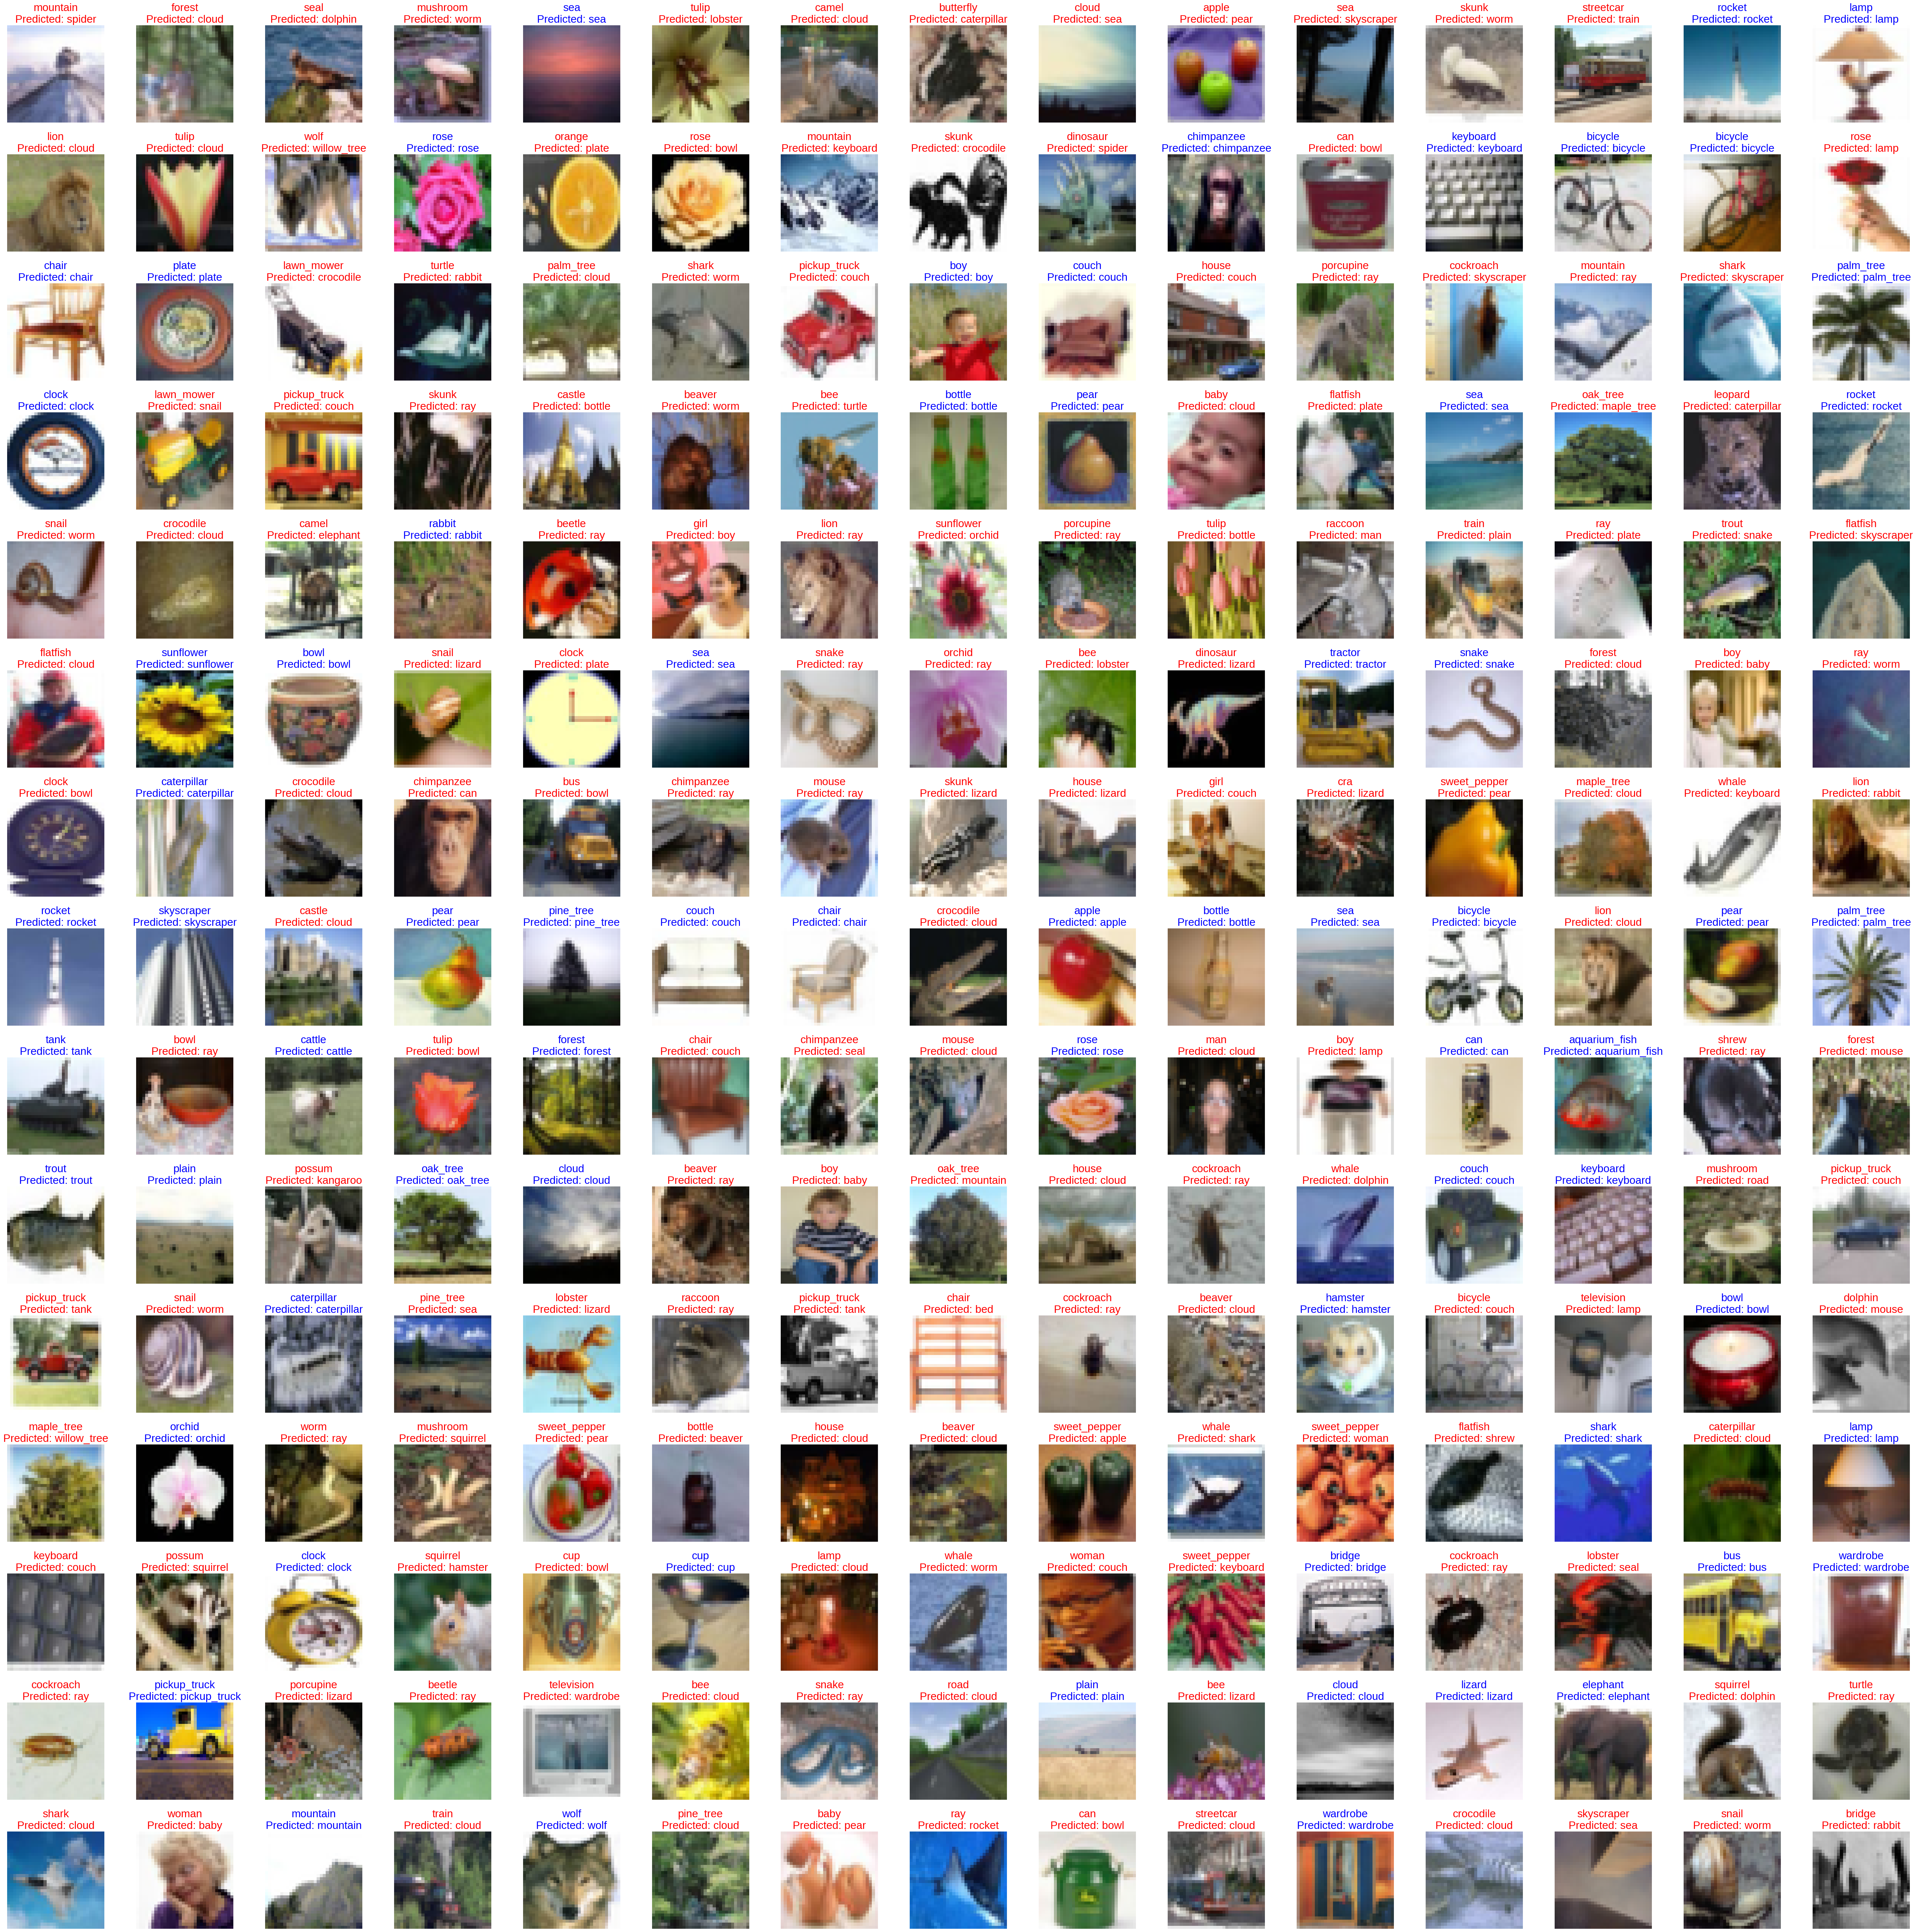

In [35]:
# Plot settings
panel_sz = 4
grid = 15
fig, axes = plt.subplots(nrows=grid, ncols=grid, figsize=(grid * panel_sz, grid * panel_sz))

# Visualization loop
for r in range(grid):
    for c in range(grid):
        ind = grid * r + c
        true_idx = int(y100_test_vis[ind])
        pred_idx = int(y_pred[ind])
        
        axes[r, c].imshow(x100_test_vis[ind])
        axes[r, c].set_xticks([])
        axes[r, c].set_yticks([])
        
        title = f'{classnames[true_idx]}\nPredicted: {classnames[pred_idx]}'
        color = 'blue' if true_idx == pred_idx else 'red'
        axes[r, c].set_title(title, color=color)

plt.tight_layout()
plt.show()

### 8f. Questions

**Question 5:** Take a look at the above montage. Does the mistakes made by ResNet-18 seem reasonable? Provide some specific examples to support your conclusion.

**Answer 5:**
Some of the mistakes are quite reasonable. For example, mistaking a snake for a worm or a cup for a can. But there a plenty of mistakes that don't make sense. It seems to perform poorly on these set of images. Its hard to get a good gague of good vs bad mistakes.

## Extensions

### General guidelines

1. Never integrate extensions into your base project so that they change the expected behavior of core functions. If your extension changes the core design/behavior, no problem, duplicate your working base project and add features from there.
2. Check the rubric to keep in mind how extensions on this project will be graded.
3. While I may consult your code and "written log" of what you did, **I am grading your extensions based on what you present in your 3-5 min video.**
3. I suggest documenting your explorations in a "log" or "lab notebook" style (i.e. documenting your thought/progression/discovery/learning process). I'm not grading your writing, so you can keep it succinct. **Whatever is most useful to you to remember what you did.** 
4. I suggest taking a hypothesis driven approach. For example "I was curious about X so I explored Y. I found Z, which was not what I expected because..., so then tried A..."
5. Make plots to help showcase your results.
6. **More is not necessarily better.** Generally, a small number of "in-depth" extensions count for more than many "shallow" extensions.

### AI guidelines

You may use AI in mostly any capacity for extensions. However, keep in mind:
1. There is no need to use AI at all!
2. You are welcome to use AI as a tool (e.g. automate something that is tedious, help you get unstuck, etc.). However, you should be coding, you should be thinking, you should be writing, you should be creating. If you are spending most (or even close to most) of your time typing into a chatbot and copy-pasting, you have probably gone too far with AI use.
3. I don't find large volumes of AI generated code/text/plots to be particularly impressive and you risk losing my interest while grading. Remember: I'm grading your extensions based on your video presentation. **More is not necessarily better.**

### Video guidelines

1. Please try to keep your video to 5 minutes (*I have other projects to grade!*). If you turn in a longer video, I make no promise that I will watch more than 5 minutes.
2. Your screen should be shared as you show me what you did. A live video of your face should also appear somewhere on the screen (e.g. picture-in-picture overlay / split screen).
3. Your partner should join you for the video and take turns talking, but, if necessary, it is fine to have one team member present during the record the video.
4. Do not simply read text from your notebook, do not read from a prepared script. I am not grading how polished your video presentation is (see extension grading criteria on rubric). 
5. I am looking for original and creative explorations sparked by your curiosity/interest/passion in a topic. This should be apparent in your video.
6. Be natural,, don't feel the need to impress me with fancy language. If it is helpful, imagine that we are talking one-on-one about your extension. Tell me what you did :)

### Extension ideas

#### 1. ResNet-34

Create and train the well-known network of the ResNet family called ResNet-34. Here is a suggested network configuration to experiment with:

```
block_units = [64, 128, 256, 512]
num_blocks = [3, 4, 6, 3]
first_block_strides = [1, 2, 2, 2]
```

#### 2. ResNet-50

Create and train the well-known network of the ResNet family called ResNet-50. Given its depth, it uses a "Bottleneck block" rather than a normal Residual Block, but the overall structure is very similar. Here is a suggested network configuration to experiment with:

```
block_units = [64, 128, 256, 512]
num_blocks = [3, 4, 6, 3]
first_block_strides = [1, 2, 2, 2]
```

#### 3. VGG networks on CIFAR-100

How does one or more of your VGG networks do at classifying images in CIFAR-100?

#### 4. Other ResNets on CIFAR-10

How do the other ResNets do at classifying images in CIFAR-10?

#### 5. Multi-network comparison

Compare the accuracy, efficiency, etc of any number of networks from the VGG, Inception Net, and ResNet families.

#### 6. Add support for saving/loading network weights

A key limitation of your current deep learning library is that parameters that capture the learning in networks are completely reset/lost/wiped out when the notebook kernel is terminated. Add (and test!) support for saving network parameters to disk after (or periodically during) training. Add (and test!) support for loading network parameters back into the network from disk before training. 

Be careful to include the moving mean and standard deviation parameters in batch normalization layers otherwise the whole net will not work!

#### 7. Other image datasets

Apply any of the three deep network families to another dataset of your choice. 

#### 8. Hyperparameter tuning

Try and find hyperparameters that allow Inception Net and the ResNets to achieve better accuracy on CIFAR-10 and/or CIFAR-100.

#### 9. Build other Inception Nets

We only built a single network, but just like VGG and ResNet, you can modify the network depth while following the computational motifs of the Inception Net architecture. Design and experiment with your own Inception Net!

#### 10. Analyze errors made by one or more of the nets

Make a confusion matrix for CIFAR-10 or CIFAR-100 (*a challenge to make it useful!*).

Visualize the predictions made by Inception Net and/or a VGG net, perhaps similar what was done with the ResNet.